<a href="https://colab.research.google.com/github/agarr3/vajra-new-2/blob/main/AE_HYBRID_COMBINED_96.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
from tqdm import tqdm_notebook as tqdm
from sklearn.preprocessing import LabelEncoder
from PIL import Image
import matplotlib.pyplot as plt
import torch
# Neural networks can be constructed using the torch.nn package.
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data.sampler import SubsetRandomSampler
from torch.utils.data import Dataset
import torchvision
import torchvision.transforms as transforms

import IPython.display as ipd

import random

In [13]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
#settings
batch_size = 64
validation_split = .3
shuffle_dataset = True
random_seed= 42
reduction_loss = "mean"
if reduction_loss == "mean":
  criterion = nn.MSELoss(reduction="mean")
elif reduction_loss == "sum":
  criterion = nn.MSELoss(reduction="sum")
n_epochs = 30
print_every = 1

BASE_PATH = "/content/gdrive/My Drive/vajra/AE_HYBRID_COMBINED/"

input_bins = 96
seq_len=200
AE_encoded_dim = 64

class_level_loss_mode = "test"

print(device)

cuda:0


In [4]:
from google.colab import drive
drive._mount('/content/gdrive')

Mounted at /content/gdrive


In [5]:
DATA_BASE_PATH = "/content/gdrive/My Drive/vajra/songs-vajra-data/MEL/"
DATA_SONG_DIR = "96Bins"
DATA_IMG_DIR = "96Bins"

files = []
western_files = []
exclusion = ["098567.npy","098569.npy", '098565.npy']
for r,d, fileList in os.walk(os.path.join(DATA_BASE_PATH, DATA_SONG_DIR, "Western_numpy")):
  for file in fileList:
    if(file not in exclusion):
      western_files.append([file,file, "Western_numpy"])
    else:
      print(file)

# random.seed(1234)
# western_files = random.sample(western_files, 2008)

indian_files = []
for r,d, fileList in os.walk(os.path.join(DATA_BASE_PATH, DATA_SONG_DIR, "Indian_numpy")):
  for file in fileList:
    if(True):
      indian_files.append([file,file, "Indian_numpy"])
    else:
      print(file)

files = indian_files + western_files
dataDF = pd.DataFrame(files, columns=['Images','songs','labels'])
dataDF.head()

Images                    songs        labels
0  BlametheNight_mel_2.npy  BlametheNight_mel_2.npy  Indian_numpy
1       DilChori_mel_0.npy       DilChori_mel_0.npy  Indian_numpy
2       DilChori_mel_1.npy       DilChori_mel_1.npy  Indian_numpy
3       DilChori_mel_2.npy       DilChori_mel_2.npy  Indian_numpy
4        Malhari_mel_0.npy        Malhari_mel_0.npy  Indian_numpy

In [6]:
dataDF.groupby("labels").count()

Images  songs
labels                      
Indian_numpy     4022   4022
Western_numpy    4000   4000

/content/gdrive/My Drive/vajra/songs-vajra-data/MEL/96Bins/Indian_numpy/Phurrr_mel_0.npy
66.88937


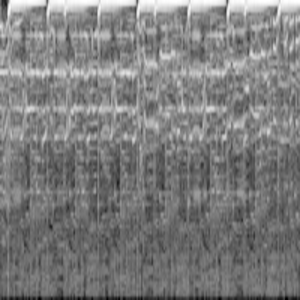

In [7]:
test_idx = random. randint(0,1000)
test_img_path = os.path.join(DATA_BASE_PATH, DATA_IMG_DIR, dataDF.loc[test_idx, 'labels'], dataDF.loc[test_idx, 'Images'])
print(test_img_path)

numpy_arr = np.load(test_img_path)

array = numpy_arr*-1
print(array.max())
array *= (255.0/array.max())
array = 255 - array

test_image = Image.fromarray(array)
test_image = test_image.convert('L')
test_image = test_image.resize((300,300))
test_image



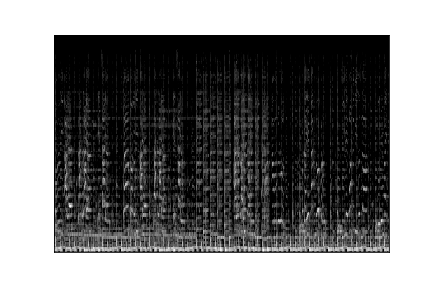

In [8]:
test_img_path = '/content/gdrive/My Drive/Kaggle/GTZAN/Data/images_original/reggae/reggae00016.png'
test_image = Image.open(test_img_path)
test_image = test_image.convert('RGB').convert('L')
test_image

In [9]:
lb = LabelEncoder()
dataDF['encoded_labels'] = lb.fit_transform(dataDF['labels'])
dataDF.head()

Images  ... encoded_labels
0  BlametheNight_mel_2.npy  ...              0
1       DilChori_mel_0.npy  ...              0
2       DilChori_mel_1.npy  ...              0
3       DilChori_mel_2.npy  ...              0
4        Malhari_mel_0.npy  ...              0

[5 rows x 4 columns]

In [10]:
classes = ('Indian_numpy', 'Western_numpy')
dataDF.groupby(by=['labels','encoded_labels']).count()

Images  songs
labels        encoded_labels               
Indian_numpy  0                 4022   4022
Western_numpy 1                 4000   4000

In [11]:
from sklearn.model_selection import train_test_split

dataDF = dataDF.sample(frac=1)
df_train, df_test = train_test_split(dataDF, test_size=validation_split, stratify=dataDF[["labels"]], random_state=9)

df_train = df_train.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)


if class_level_loss_mode == "test":
  western_dataDF = df_test[df_test['labels'] == "Western_numpy"]
  western_dataDF = western_dataDF.reset_index(drop=True)
  indian_dataDF = df_test[df_test['labels'] == "Indian_numpy"]
  indian_dataDF = indian_dataDF.reset_index(drop=True)

In [12]:
df_train.groupby(by=['labels','encoded_labels']).count()

Images  songs
labels        encoded_labels               
Indian_numpy  0                 2815   2815
Western_numpy 1                 2800   2800

In [14]:
df_test.groupby(by=['labels','encoded_labels']).count()

Images  songs
labels        encoded_labels               
Indian_numpy  0                 1207   1207
Western_numpy 1                 1200   1200

In [15]:
indian_dataDF.groupby(by=['labels','encoded_labels']).count()

Images  songs
labels       encoded_labels               
Indian_numpy 0                 1207   1207

In [16]:
transform_normal = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

transform = transforms.Compose(
    [transforms.ToTensor()])

In [17]:
class MEL_Dataset(Dataset):
    def __init__(self, img_data,img_path,transform=None):
        self.img_path = img_path
        self.transform = transform
        self.img_data = img_data
        
    def __len__(self):
        return len(self.img_data)
    
    def __getitem__(self, index):
        img_name = os.path.join(self.img_path,self.img_data.loc[index, 'labels'],
                                self.img_data.loc[index, 'Images'])
        image = np.load(img_name)
        data = torch.tensor(image[:,:seq_len], dtype=torch.float)
        data = data.permute(1, 0)
        label = torch.tensor(self.img_data.loc[index, 'encoded_labels'])
        fileName = self.img_data.loc[index, 'Images']
        return data, label, fileName



In [18]:
train_dataset = MEL_Dataset(df_train,os.path.join(DATA_BASE_PATH, DATA_IMG_DIR),transform)
test_dataset = MEL_Dataset(df_test,os.path.join(DATA_BASE_PATH, DATA_IMG_DIR),transform)

In [19]:
trainloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size)
testloader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size)

In [20]:
indian_dataset = MEL_Dataset(indian_dataDF,os.path.join(DATA_BASE_PATH, DATA_IMG_DIR),transform)
western_dataset = MEL_Dataset(western_dataDF,os.path.join(DATA_BASE_PATH, DATA_IMG_DIR),transform)

indian_loader = torch.utils.data.DataLoader(indian_dataset, batch_size=batch_size)
western_loader = torch.utils.data.DataLoader(western_dataset, batch_size=batch_size)


In [21]:
def mel_display(S_DB):
    S_DB = S_DB.numpy()
    array = S_DB*-1
    array *= (255.0/array.max())
    #array = 255 - array
    array = np.transpose(array, (2, 1, 0))
    return array.squeeze()

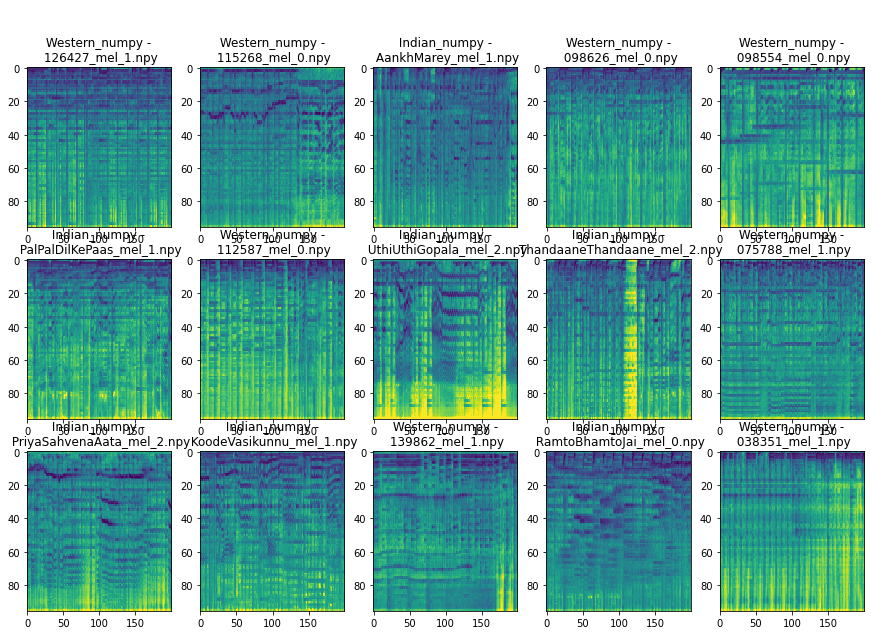

In [22]:
# get some random training images
dataiter = iter(trainloader)
images, labels, fileNames = dataiter.next()
arthopod_types = {0: 'Indian_numpy', 1: 'Western_numpy', 2: 'country', 3: 'disco', 4: 'hiphop', 5: 'jazz', 6: 'metal', 7: 'pop', 8: 'reggae', 9: 'rock'}
# Viewing data examples used for training
fig, axis = plt.subplots(3, 5, figsize=(15, 10))
for i, ax in enumerate(axis.flat):
    with torch.no_grad():
        image, label, fileName = images[i], labels[i], fileNames[i]
        ax.imshow(mel_display(image.unsqueeze(dim=0)), interpolation='nearest', aspect='auto') # add image
        ax.set(title = f"\n \n {arthopod_types[label.item()]} - \n {fileName}") # add label

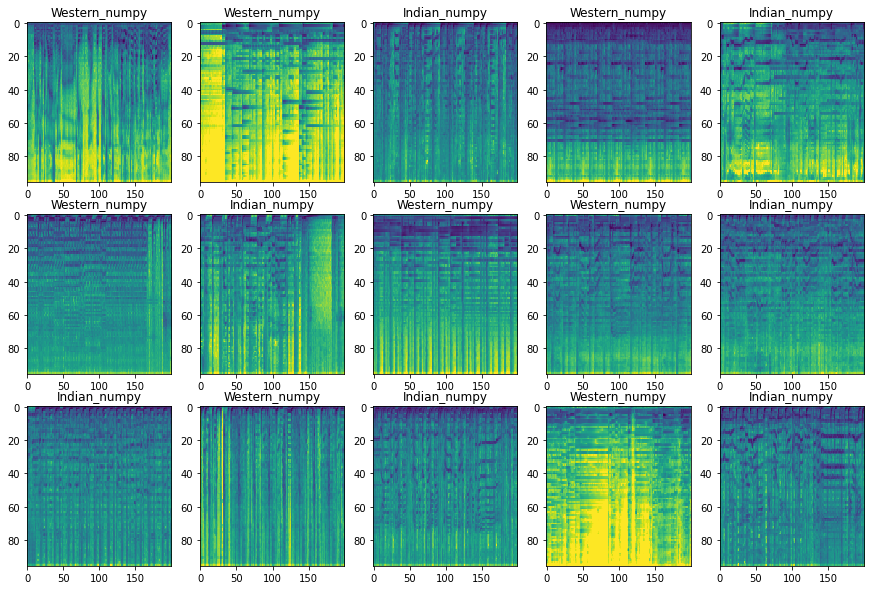

In [23]:
# get some random training images
dataiter = iter(testloader)
images, labels, fileNames = dataiter.next()
arthopod_types = {0: 'Indian_numpy', 1: 'Western_numpy', 2: 'country', 3: 'disco', 4: 'hiphop', 5: 'jazz', 6: 'metal', 7: 'pop', 8: 'reggae', 9: 'rock'}
# Viewing data examples used for training
fig, axis = plt.subplots(3, 5, figsize=(15, 10))
for i, ax in enumerate(axis.flat):
    with torch.no_grad():
        image, label = images[i], labels[i]
        ax.imshow(mel_display(image.unsqueeze(dim=0)), interpolation='nearest', aspect='auto') # add image
        ax.set(title = f"{arthopod_types[label.item()]}") # add label

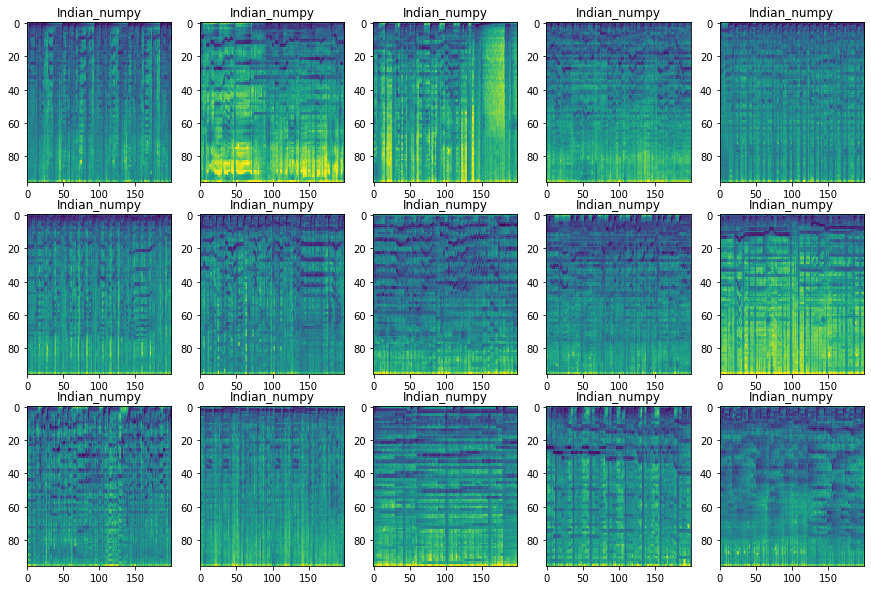

In [24]:
# get some random training images
dataiter = iter(indian_loader)
images, labels, fileNames = dataiter.next()
arthopod_types = {0: 'Indian_numpy', 1: 'Western_numpy', 2: 'country', 3: 'disco', 4: 'hiphop', 5: 'jazz', 6: 'metal', 7: 'pop', 8: 'reggae', 9: 'rock'}
# Viewing data examples used for training
fig, axis = plt.subplots(3, 5, figsize=(15, 10))
for i, ax in enumerate(axis.flat):
    with torch.no_grad():
        image, label = images[i], labels[i]
        ax.imshow(mel_display(image.unsqueeze(dim=0)), interpolation='nearest', aspect='auto') # add image
        ax.set(title = f"{arthopod_types[label.item()]}") # add label

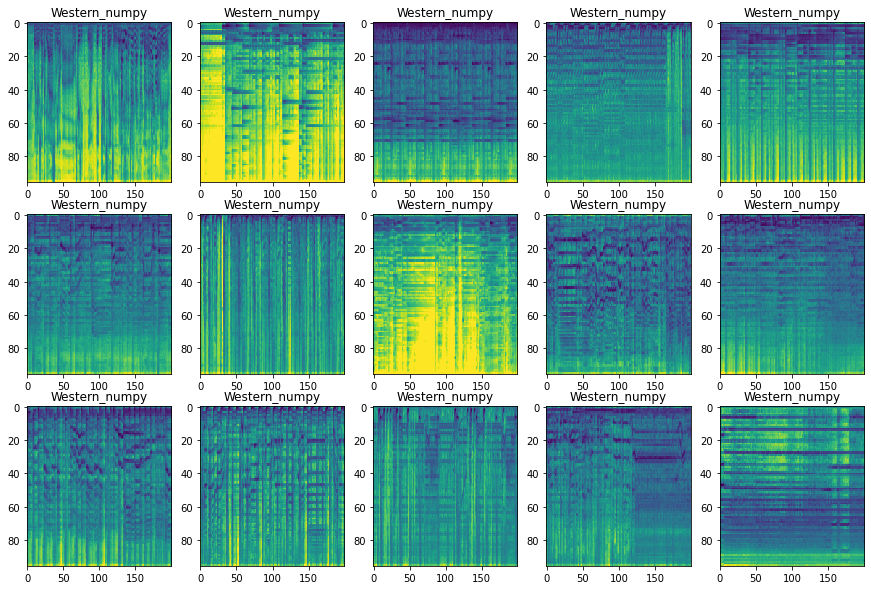

In [25]:
# get some random training images
dataiter = iter(western_loader)
images, labels, fileNames = dataiter.next()
arthopod_types = {0: 'Indian_numpy', 1: 'Western_numpy', 2: 'country', 3: 'disco', 4: 'hiphop', 5: 'jazz', 6: 'metal', 7: 'pop', 8: 'reggae', 9: 'rock'}
# Viewing data examples used for training
fig, axis = plt.subplots(3, 5, figsize=(15, 10))
for i, ax in enumerate(axis.flat):
    with torch.no_grad():
        image, label = images[i], labels[i]
        ax.imshow(mel_display(image.unsqueeze(dim=0)), interpolation='nearest', aspect='auto') # add image
        ax.set(title = f"{arthopod_types[label.item()]}") # add label

In [26]:
class Encoder(torch.nn.Module):
  def __init__(self, seq_len, n_features, embedding_dim=64, kernel_size=[4,3,2], stride=[1,1,1]):
    super(Encoder, self).__init__()
    self.seq_len, self.n_features = seq_len, n_features
    self.embedding_dim, self.hidden_dim = embedding_dim, 2 * embedding_dim


    self.conv = nn.Conv1d(in_channels=seq_len,out_channels=seq_len,kernel_size=kernel_size[0],stride=stride[0], groups=seq_len)
    conv_op_dim = int(((n_features - kernel_size[0])/ stride[0]) + 1)

    self.conv_1 = nn.Conv1d(in_channels=seq_len,out_channels=seq_len,kernel_size=kernel_size[1],stride=stride[1], groups=seq_len)
    conv_op_dim1 = int(((conv_op_dim - kernel_size[1])/ stride[1]) + 1)

    self.conv_2 = nn.Conv1d(in_channels=seq_len,out_channels=seq_len,kernel_size=kernel_size[2],stride=stride[2], groups=seq_len)
    conv_op_dim2 = int(((conv_op_dim1 - kernel_size[2])/ stride[2]) + 1)

    self.rnn1 = nn.LSTM(
      input_size=conv_op_dim2,
      hidden_size=self.hidden_dim,
      num_layers=1,
      batch_first=True
    )
    self.rnn2 = nn.LSTM(
      input_size=self.hidden_dim,
      hidden_size=embedding_dim,
      num_layers=1,
      batch_first=True
    )
  def forward(self, x):
    x = self.conv(x)
    x = self.conv_1(x)
    x = self.conv_2(x)
    lstm_l1_op, (_, _) = self.rnn1(x)
    lstm_l2_op, (hidden_n, _) = self.rnn2(lstm_l1_op)
    return lstm_l2_op, lstm_l1_op

class Decoder(torch.nn.Module):
  def __init__(self, seq_len, embedding_dim=64, n_features=26):
    super(Decoder, self).__init__()
    self.seq_len, self.embedding_dim = seq_len, embedding_dim
    self.hidden_dim, self.n_features = 2 * embedding_dim, n_features
    self.rnn1 = nn.LSTM(
      input_size=embedding_dim,
      hidden_size=embedding_dim,
      num_layers=1,
      batch_first=True
    )
    self.rnn2 = nn.LSTM(
      input_size=embedding_dim,
      hidden_size=self.hidden_dim,
      num_layers=1,
      batch_first=True
    )
    self.output_layer = nn.Linear(self.hidden_dim * self.seq_len, n_features * self.seq_len)
  def forward(self, x):
    x, (hidden_n, cell_n) = self.rnn1(x)
    x, (hidden_n, cell_n) = self.rnn2(x)
    x = x.contiguous()
    x = x.view(x.shape[0], -1)
    x = self.output_layer(x)
    return x.reshape(x.shape[0],self.seq_len, self.n_features)

class RecurrentAutoencoder(torch.nn.Module):
  def __init__(self, seq_len, n_features, embedding_dim=64, device='cpu'):
    super(RecurrentAutoencoder, self).__init__()
    self.encoder = Encoder(seq_len, n_features, embedding_dim).to(device)
    self.decoder = Decoder(seq_len, embedding_dim, n_features).to(device)
  def forward(self, x):
    x, l1_op = self.encoder(x)
    x = self.decoder(x)
    return x

net = RecurrentAutoencoder(seq_len, input_bins, AE_encoded_dim, device=device)
net.to(device)


RecurrentAutoencoder(
  (encoder): Encoder(
    (conv): Conv1d(200, 200, kernel_size=(4,), stride=(1,), groups=200)
    (conv_1): Conv1d(200, 200, kernel_size=(3,), stride=(1,), groups=200)
    (conv_2): Conv1d(200, 200, kernel_size=(2,), stride=(1,), groups=200)
    (rnn1): LSTM(90, 128, batch_first=True)
    (rnn2): LSTM(128, 64, batch_first=True)
  )
  (decoder): Decoder(
    (rnn1): LSTM(64, 64, batch_first=True)
    (rnn2): LSTM(64, 128, batch_first=True)
    (output_layer): Linear(in_features=25600, out_features=19200, bias=True)
  )
)

In [27]:
optimizer = torch.optim.Adam(net.parameters(), lr=0.001)

In [28]:
import matplotlib.pyplot as plt
import numpy as np

def visualize(train_loss_graph, test_loss_graph):
  x = range(len(train_loss_graph))
      
  # plot lines
  plt.plot(x, train_loss_graph, label = "Training Loss")
  plt.plot(x, test_loss_graph, label = "Test Loss")
  
  plt.legend()
  plt.show()


def visualize_class_loss(in_loss_graph, we_loss_graph):
  x = range(len(in_loss_graph))
      
  # plot lines
  plt.plot(x, in_loss_graph, label = "Indian Loss")
  plt.plot(x, we_loss_graph, label = "Western Loss")
  
  plt.legend()
  plt.show()


[1,     1] loss: 1683.593
[1,     2] loss: 1689.913
[1,     3] loss: 1694.666
[1,     4] loss: 1470.051
[1,     5] loss: 1171.046
[1,     6] loss: 969.471
[1,     7] loss: 681.767
[1,     8] loss: 370.460
[1,     9] loss: 261.096
[1,    10] loss: 479.745
[1,    11] loss: 249.722
[1,    12] loss: 120.516
[1,    13] loss: 147.198
[1,    14] loss: 181.106
[1,    15] loss: 209.484
[1,    16] loss: 270.888
[1,    17] loss: 169.435
[1,    18] loss: 222.586
[1,    19] loss: 131.917
[1,    20] loss: 142.798
[1,    21] loss: 156.363
[1,    22] loss: 156.606
[1,    23] loss: 192.625
[1,    24] loss: 184.963
[1,    25] loss: 154.603
[1,    26] loss: 134.364
[1,    27] loss: 118.861
[1,    28] loss: 105.881
[1,    29] loss: 145.439
[1,    30] loss: 121.402
[1,    31] loss: 162.353
[1,    32] loss: 142.318
[1,    33] loss: 174.633
[1,    34] loss: 123.817
[1,    35] loss: 126.240
[1,    36] loss: 129.493
[1,    37] loss: 125.550
[1,    38] loss: 135.425
[1,    39] loss: 140.359
[1,    40] loss: 136

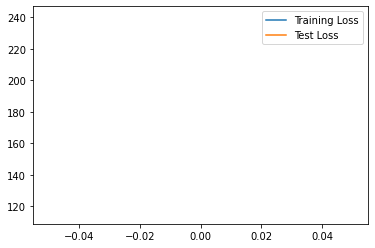

LOSS of the network on the test images: 1746 %
Mean of the network on the Indian images after epoch 0 is 97.0043830871582
LOSS of the network on the test images: 2522 %
Mean of the network on the Western images after epoch 0 is 140.15039274427625


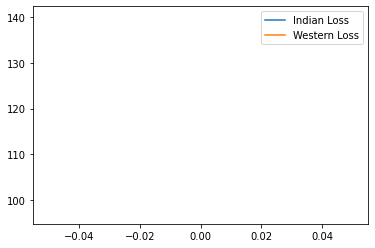

[2,     1] loss: 107.193
[2,     2] loss: 115.459
[2,     3] loss: 116.331
[2,     4] loss: 126.795
[2,     5] loss: 97.731
[2,     6] loss: 105.857
[2,     7] loss: 101.138
[2,     8] loss: 110.857
[2,     9] loss: 104.887
[2,    10] loss: 100.164
[2,    11] loss: 94.580
[2,    12] loss: 86.227
[2,    13] loss: 103.840
[2,    14] loss: 95.401
[2,    15] loss: 88.966
[2,    16] loss: 109.922
[2,    17] loss: 82.375
[2,    18] loss: 111.842
[2,    19] loss: 83.784
[2,    20] loss: 92.897
[2,    21] loss: 95.487
[2,    22] loss: 78.205
[2,    23] loss: 96.221
[2,    24] loss: 87.368
[2,    25] loss: 90.801
[2,    26] loss: 79.398
[2,    27] loss: 86.790
[2,    28] loss: 82.333
[2,    29] loss: 88.591
[2,    30] loss: 82.942
[2,    31] loss: 88.085
[2,    32] loss: 86.272
[2,    33] loss: 88.577
[2,    34] loss: 89.689
[2,    35] loss: 85.967
[2,    36] loss: 81.888
[2,    37] loss: 83.220
[2,    38] loss: 88.236
[2,    39] loss: 84.630
[2,    40] loss: 84.575
[2,    41] loss: 88.923
[2, 

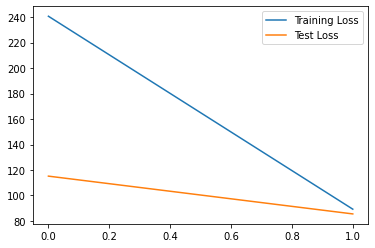

LOSS of the network on the test images: 1482 %
Mean of the network on the Indian images after epoch 1 is 82.34085167778863
LOSS of the network on the test images: 1685 %
Mean of the network on the Western images after epoch 1 is 93.61856757269965


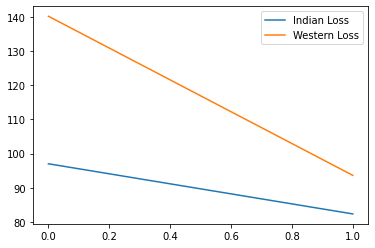

[3,     1] loss: 79.253
[3,     2] loss: 91.497
[3,     3] loss: 92.856
[3,     4] loss: 90.814
[3,     5] loss: 73.883
[3,     6] loss: 84.905
[3,     7] loss: 80.520
[3,     8] loss: 77.970
[3,     9] loss: 81.081
[3,    10] loss: 75.786
[3,    11] loss: 77.594
[3,    12] loss: 73.565
[3,    13] loss: 82.585
[3,    14] loss: 80.966
[3,    15] loss: 76.733
[3,    16] loss: 95.555
[3,    17] loss: 77.829
[3,    18] loss: 87.813
[3,    19] loss: 75.495
[3,    20] loss: 83.153
[3,    21] loss: 85.458
[3,    22] loss: 73.664
[3,    23] loss: 87.937
[3,    24] loss: 83.793
[3,    25] loss: 82.460
[3,    26] loss: 73.326
[3,    27] loss: 82.657
[3,    28] loss: 74.936
[3,    29] loss: 85.267
[3,    30] loss: 78.551
[3,    31] loss: 85.693
[3,    32] loss: 81.241
[3,    33] loss: 85.692
[3,    34] loss: 86.218
[3,    35] loss: 83.195
[3,    36] loss: 77.773
[3,    37] loss: 81.344
[3,    38] loss: 85.813
[3,    39] loss: 81.952
[3,    40] loss: 81.729
[3,    41] loss: 87.054
[3,    42] loss:

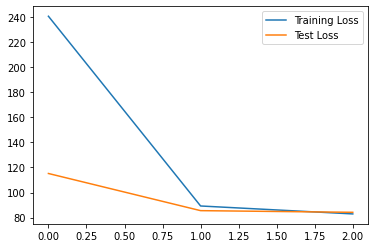

LOSS of the network on the test images: 1463 %
Mean of the network on the Indian images after epoch 2 is 81.3081169128418
LOSS of the network on the test images: 1654 %
Mean of the network on the Western images after epoch 2 is 91.91625849405925


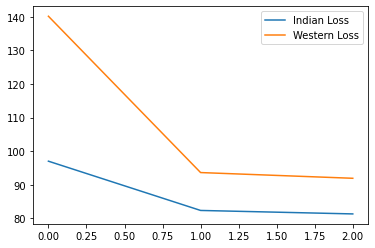

[4,     1] loss: 78.021
[4,     2] loss: 90.114
[4,     3] loss: 91.825
[4,     4] loss: 88.679
[4,     5] loss: 73.200
[4,     6] loss: 83.723
[4,     7] loss: 79.558
[4,     8] loss: 76.271
[4,     9] loss: 79.984
[4,    10] loss: 74.990
[4,    11] loss: 76.281
[4,    12] loss: 72.970
[4,    13] loss: 81.527
[4,    14] loss: 80.590
[4,    15] loss: 75.542
[4,    16] loss: 93.946
[4,    17] loss: 77.251
[4,    18] loss: 85.776
[4,    19] loss: 75.741
[4,    20] loss: 81.695
[4,    21] loss: 84.881
[4,    22] loss: 73.685
[4,    23] loss: 86.491
[4,    24] loss: 83.639
[4,    25] loss: 81.027
[4,    26] loss: 72.685
[4,    27] loss: 81.621
[4,    28] loss: 74.326
[4,    29] loss: 83.692
[4,    30] loss: 77.796
[4,    31] loss: 84.905
[4,    32] loss: 80.402
[4,    33] loss: 84.523
[4,    34] loss: 85.970
[4,    35] loss: 82.646
[4,    36] loss: 76.537
[4,    37] loss: 79.916
[4,    38] loss: 84.338
[4,    39] loss: 81.107
[4,    40] loss: 80.833
[4,    41] loss: 84.985
[4,    42] loss:

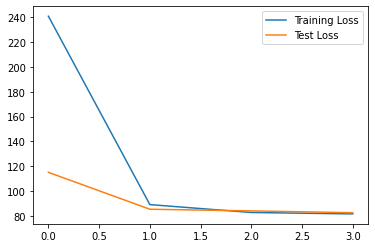

LOSS of the network on the test images: 1443 %
Mean of the network on the Indian images after epoch 3 is 80.18054283989801
LOSS of the network on the test images: 1621 %
Mean of the network on the Western images after epoch 3 is 90.05687374538846


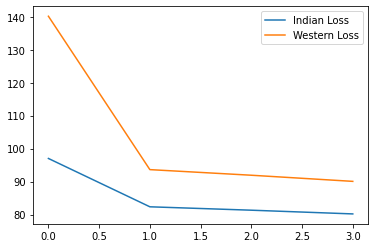

[5,     1] loss: 76.781
[5,     2] loss: 88.637
[5,     3] loss: 90.455
[5,     4] loss: 86.803
[5,     5] loss: 72.606
[5,     6] loss: 82.540
[5,     7] loss: 78.531
[5,     8] loss: 74.720
[5,     9] loss: 79.238
[5,    10] loss: 74.024
[5,    11] loss: 74.873
[5,    12] loss: 72.486
[5,    13] loss: 80.493
[5,    14] loss: 80.125
[5,    15] loss: 74.634
[5,    16] loss: 91.914
[5,    17] loss: 76.700
[5,    18] loss: 83.510
[5,    19] loss: 74.986
[5,    20] loss: 80.623
[5,    21] loss: 83.633
[5,    22] loss: 73.044
[5,    23] loss: 85.236
[5,    24] loss: 81.906
[5,    25] loss: 79.836
[5,    26] loss: 71.575
[5,    27] loss: 80.760
[5,    28] loss: 73.682
[5,    29] loss: 81.742
[5,    30] loss: 77.294
[5,    31] loss: 84.134
[5,    32] loss: 79.369
[5,    33] loss: 83.483
[5,    34] loss: 84.949
[5,    35] loss: 81.690
[5,    36] loss: 75.843
[5,    37] loss: 78.201
[5,    38] loss: 82.658
[5,    39] loss: 80.072
[5,    40] loss: 79.925
[5,    41] loss: 83.026
[5,    42] loss:

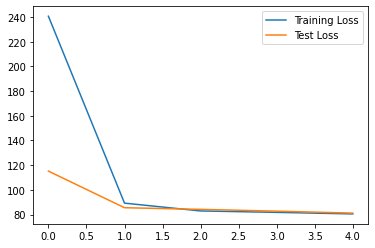

LOSS of the network on the test images: 1419 %
Mean of the network on the Indian images after epoch 4 is 78.85901938544379
LOSS of the network on the test images: 1585 %
Mean of the network on the Western images after epoch 4 is 88.10799831814236


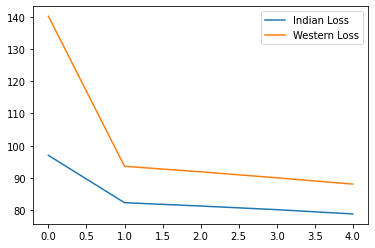

[6,     1] loss: 75.527
[6,     2] loss: 86.498
[6,     3] loss: 88.188
[6,     4] loss: 83.919
[6,     5] loss: 71.913
[6,     6] loss: 80.635
[6,     7] loss: 77.212
[6,     8] loss: 72.672
[6,     9] loss: 78.003
[6,    10] loss: 72.746
[6,    11] loss: 72.660
[6,    12] loss: 71.520
[6,    13] loss: 78.765
[6,    14] loss: 79.022
[6,    15] loss: 73.003
[6,    16] loss: 89.061
[6,    17] loss: 75.589
[6,    18] loss: 80.774
[6,    19] loss: 73.597
[6,    20] loss: 78.932
[6,    21] loss: 82.083
[6,    22] loss: 71.754
[6,    23] loss: 83.341
[6,    24] loss: 79.821
[6,    25] loss: 77.705
[6,    26] loss: 69.855
[6,    27] loss: 78.976
[6,    28] loss: 71.922
[6,    29] loss: 78.995
[6,    30] loss: 75.590
[6,    31] loss: 82.224
[6,    32] loss: 77.066
[6,    33] loss: 80.949
[6,    34] loss: 82.493
[6,    35] loss: 79.493
[6,    36] loss: 73.927
[6,    37] loss: 74.951
[6,    38] loss: 78.893
[6,    39] loss: 77.000
[6,    40] loss: 76.751
[6,    41] loss: 78.937
[6,    42] loss:

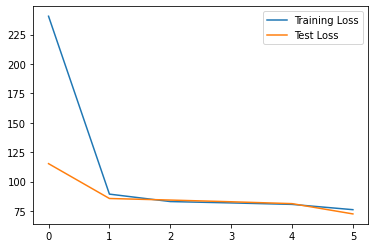

LOSS of the network on the test images: 1318 %
Mean of the network on the Indian images after epoch 5 is 73.24230363633897
LOSS of the network on the test images: 1363 %
Mean of the network on the Western images after epoch 5 is 75.73243183559842


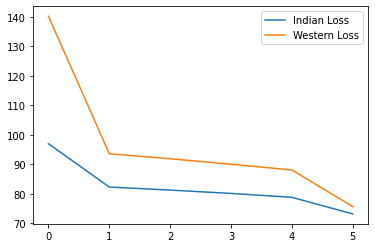

[7,     1] loss: 69.304
[7,     2] loss: 76.740
[7,     3] loss: 76.678
[7,     4] loss: 75.286
[7,     5] loss: 66.804
[7,     6] loss: 70.505
[7,     7] loss: 68.798
[7,     8] loss: 66.074
[7,     9] loss: 71.295
[7,    10] loss: 65.667
[7,    11] loss: 65.649
[7,    12] loss: 63.939
[7,    13] loss: 70.384
[7,    14] loss: 71.441
[7,    15] loss: 65.417
[7,    16] loss: 80.864
[7,    17] loss: 67.638
[7,    18] loss: 73.249
[7,    19] loss: 65.531
[7,    20] loss: 69.405
[7,    21] loss: 70.564
[7,    22] loss: 65.129
[7,    23] loss: 74.484
[7,    24] loss: 70.111
[7,    25] loss: 69.188
[7,    26] loss: 62.238
[7,    27] loss: 68.838
[7,    28] loss: 64.811
[7,    29] loss: 67.878
[7,    30] loss: 68.568
[7,    31] loss: 72.165
[7,    32] loss: 68.425
[7,    33] loss: 71.471
[7,    34] loss: 71.224
[7,    35] loss: 69.842
[7,    36] loss: 67.052
[7,    37] loss: 64.576
[7,    38] loss: 68.691
[7,    39] loss: 66.584
[7,    40] loss: 64.952
[7,    41] loss: 68.464
[7,    42] loss:

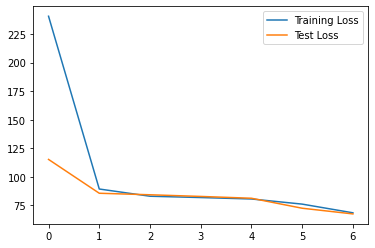

LOSS of the network on the test images: 1247 %
Mean of the network on the Indian images after epoch 6 is 69.31560028923883
LOSS of the network on the test images: 1249 %
Mean of the network on the Western images after epoch 6 is 69.40576065911188


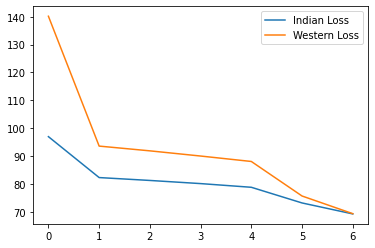

[8,     1] loss: 63.990
[8,     2] loss: 70.375
[8,     3] loss: 70.927
[8,     4] loss: 69.346
[8,     5] loss: 63.229
[8,     6] loss: 63.916
[8,     7] loss: 63.504
[8,     8] loss: 62.553
[8,     9] loss: 66.877
[8,    10] loss: 62.027
[8,    11] loss: 61.318
[8,    12] loss: 60.076
[8,    13] loss: 66.554
[8,    14] loss: 67.135
[8,    15] loss: 61.817
[8,    16] loss: 76.456
[8,    17] loss: 64.201
[8,    18] loss: 68.600
[8,    19] loss: 62.045
[8,    20] loss: 65.457
[8,    21] loss: 65.166
[8,    22] loss: 62.388
[8,    23] loss: 69.662
[8,    24] loss: 65.778
[8,    25] loss: 64.891
[8,    26] loss: 58.746
[8,    27] loss: 65.353
[8,    28] loss: 60.914
[8,    29] loss: 63.051
[8,    30] loss: 65.079
[8,    31] loss: 68.710
[8,    32] loss: 64.909
[8,    33] loss: 67.966
[8,    34] loss: 66.982
[8,    35] loss: 65.479
[8,    36] loss: 64.903
[8,    37] loss: 61.157
[8,    38] loss: 64.317
[8,    39] loss: 63.528
[8,    40] loss: 61.301
[8,    41] loss: 64.602
[8,    42] loss:

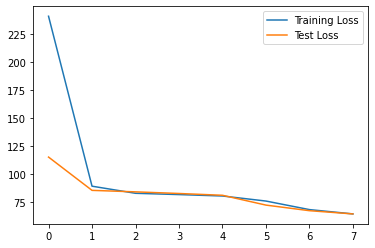

LOSS of the network on the test images: 1206 %
Mean of the network on the Indian images after epoch 7 is 67.04741477966309
LOSS of the network on the test images: 1183 %
Mean of the network on the Western images after epoch 7 is 65.7483736673991


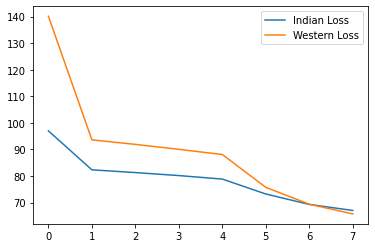

[9,     1] loss: 61.237
[9,     2] loss: 67.080
[9,     3] loss: 67.113
[9,     4] loss: 65.232
[9,     5] loss: 60.456
[9,     6] loss: 60.733
[9,     7] loss: 60.705
[9,     8] loss: 59.222
[9,     9] loss: 63.843
[9,    10] loss: 60.157
[9,    11] loss: 58.725
[9,    12] loss: 57.645
[9,    13] loss: 63.803
[9,    14] loss: 64.309
[9,    15] loss: 59.070
[9,    16] loss: 73.140
[9,    17] loss: 61.113
[9,    18] loss: 65.458
[9,    19] loss: 59.175
[9,    20] loss: 62.660
[9,    21] loss: 62.464
[9,    22] loss: 60.125
[9,    23] loss: 66.262
[9,    24] loss: 62.633
[9,    25] loss: 62.742
[9,    26] loss: 56.547
[9,    27] loss: 62.872
[9,    28] loss: 59.026
[9,    29] loss: 60.766
[9,    30] loss: 62.781
[9,    31] loss: 66.605
[9,    32] loss: 62.057
[9,    33] loss: 65.055
[9,    34] loss: 64.775
[9,    35] loss: 62.582
[9,    36] loss: 63.296
[9,    37] loss: 59.524
[9,    38] loss: 61.710
[9,    39] loss: 61.645
[9,    40] loss: 58.797
[9,    41] loss: 62.019
[9,    42] loss:

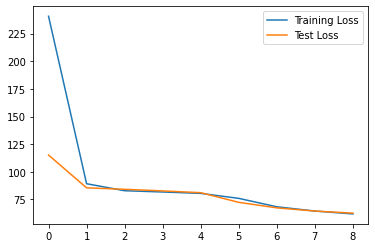

LOSS of the network on the test images: 1180 %
Mean of the network on the Indian images after epoch 8 is 65.56873236762152
LOSS of the network on the test images: 1139 %
Mean of the network on the Western images after epoch 8 is 63.28880098130968


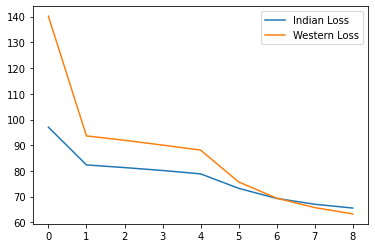

[10,     1] loss: 59.620
[10,     2] loss: 64.593
[10,     3] loss: 64.320
[10,     4] loss: 62.792
[10,     5] loss: 58.655
[10,     6] loss: 58.857
[10,     7] loss: 58.866
[10,     8] loss: 57.162
[10,     9] loss: 62.008
[10,    10] loss: 58.525
[10,    11] loss: 57.245
[10,    12] loss: 55.730
[10,    13] loss: 61.745
[10,    14] loss: 63.011
[10,    15] loss: 57.375
[10,    16] loss: 70.727
[10,    17] loss: 59.069
[10,    18] loss: 63.483
[10,    19] loss: 57.954
[10,    20] loss: 60.485
[10,    21] loss: 61.212
[10,    22] loss: 58.510
[10,    23] loss: 64.707
[10,    24] loss: 60.804
[10,    25] loss: 61.196
[10,    26] loss: 54.977
[10,    27] loss: 60.933
[10,    28] loss: 58.232
[10,    29] loss: 58.607
[10,    30] loss: 61.658
[10,    31] loss: 64.546
[10,    32] loss: 60.162
[10,    33] loss: 63.448
[10,    34] loss: 63.072
[10,    35] loss: 60.692
[10,    36] loss: 61.543
[10,    37] loss: 58.038
[10,    38] loss: 60.067
[10,    39] loss: 59.714
[10,    40] loss: 57.086


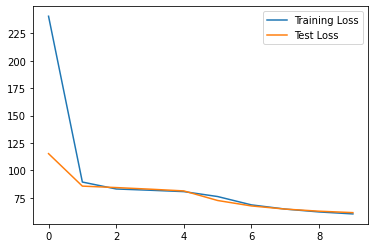

LOSS of the network on the test images: 1161 %
Mean of the network on the Indian images after epoch 9 is 64.53916189405653
LOSS of the network on the test images: 1108 %
Mean of the network on the Western images after epoch 9 is 61.59700690375434


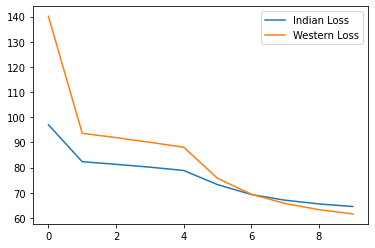

[11,     1] loss: 58.230
[11,     2] loss: 62.090
[11,     3] loss: 61.963
[11,     4] loss: 60.753
[11,     5] loss: 57.100
[11,     6] loss: 56.813
[11,     7] loss: 57.053
[11,     8] loss: 55.846
[11,     9] loss: 59.687
[11,    10] loss: 57.170
[11,    11] loss: 56.375
[11,    12] loss: 53.617
[11,    13] loss: 60.388
[11,    14] loss: 61.583
[11,    15] loss: 56.106
[11,    16] loss: 68.659
[11,    17] loss: 57.384
[11,    18] loss: 61.607
[11,    19] loss: 55.911
[11,    20] loss: 58.932
[11,    21] loss: 58.797
[11,    22] loss: 56.932
[11,    23] loss: 62.479
[11,    24] loss: 58.540
[11,    25] loss: 59.318
[11,    26] loss: 52.432
[11,    27] loss: 58.987
[11,    28] loss: 55.605
[11,    29] loss: 56.889
[11,    30] loss: 59.196
[11,    31] loss: 62.956
[11,    32] loss: 58.059
[11,    33] loss: 61.843
[11,    34] loss: 61.223
[11,    35] loss: 58.933
[11,    36] loss: 59.649
[11,    37] loss: 56.370
[11,    38] loss: 58.771
[11,    39] loss: 57.953
[11,    40] loss: 55.550


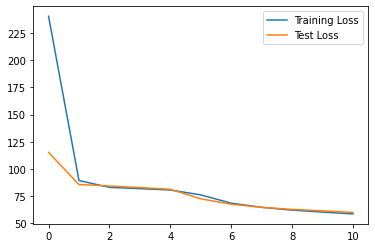

LOSS of the network on the test images: 1137 %
Mean of the network on the Indian images after epoch 10 is 63.20305718315972
LOSS of the network on the test images: 1078 %
Mean of the network on the Western images after epoch 10 is 59.893648359510635


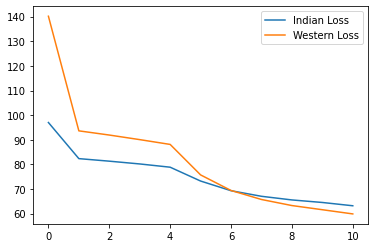

[12,     1] loss: 56.613
[12,     2] loss: 60.433
[12,     3] loss: 60.114
[12,     4] loss: 59.068
[12,     5] loss: 55.890
[12,     6] loss: 55.383
[12,     7] loss: 55.690
[12,     8] loss: 54.759
[12,     9] loss: 58.064
[12,    10] loss: 55.933
[12,    11] loss: 55.100
[12,    12] loss: 52.339
[12,    13] loss: 58.667
[12,    14] loss: 60.301
[12,    15] loss: 54.906
[12,    16] loss: 67.278
[12,    17] loss: 55.960
[12,    18] loss: 60.441
[12,    19] loss: 55.711
[12,    20] loss: 58.080
[12,    21] loss: 57.551
[12,    22] loss: 56.090
[12,    23] loss: 61.684
[12,    24] loss: 56.874
[12,    25] loss: 58.176
[12,    26] loss: 51.764
[12,    27] loss: 57.507
[12,    28] loss: 54.801
[12,    29] loss: 55.509
[12,    30] loss: 58.153
[12,    31] loss: 61.377
[12,    32] loss: 56.705
[12,    33] loss: 60.378
[12,    34] loss: 60.037
[12,    35] loss: 57.198
[12,    36] loss: 57.877
[12,    37] loss: 55.047
[12,    38] loss: 57.345
[12,    39] loss: 56.888
[12,    40] loss: 53.956


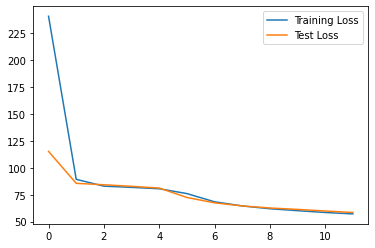

LOSS of the network on the test images: 1116 %
Mean of the network on the Indian images after epoch 11 is 62.00459331936307
LOSS of the network on the test images: 1049 %
Mean of the network on the Western images after epoch 11 is 58.28057522243924


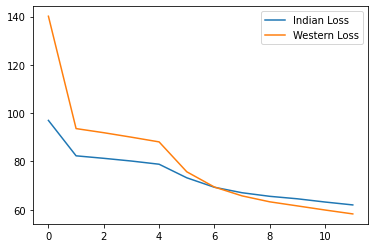

[13,     1] loss: 55.007
[13,     2] loss: 58.595
[13,     3] loss: 58.363
[13,     4] loss: 57.142
[13,     5] loss: 54.352
[13,     6] loss: 54.067
[13,     7] loss: 54.091
[13,     8] loss: 53.327
[13,     9] loss: 56.478
[13,    10] loss: 54.483
[13,    11] loss: 53.374
[13,    12] loss: 51.090
[13,    13] loss: 57.094
[13,    14] loss: 58.376
[13,    15] loss: 53.513
[13,    16] loss: 66.271
[13,    17] loss: 55.017
[13,    18] loss: 58.010
[13,    19] loss: 54.034
[13,    20] loss: 57.015
[13,    21] loss: 56.053
[13,    22] loss: 54.098
[13,    23] loss: 60.029
[13,    24] loss: 55.665
[13,    25] loss: 56.143
[13,    26] loss: 50.142
[13,    27] loss: 56.188
[13,    28] loss: 52.984
[13,    29] loss: 53.811
[13,    30] loss: 56.405
[13,    31] loss: 59.448
[13,    32] loss: 55.169
[13,    33] loss: 58.901
[13,    34] loss: 58.492
[13,    35] loss: 55.770
[13,    36] loss: 56.205
[13,    37] loss: 53.130
[13,    38] loss: 55.440
[13,    39] loss: 55.040
[13,    40] loss: 52.374


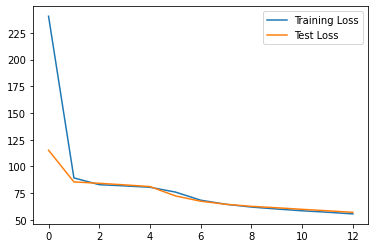

LOSS of the network on the test images: 1092 %
Mean of the network on the Indian images after epoch 12 is 60.716607411702476
LOSS of the network on the test images: 1018 %
Mean of the network on the Western images after epoch 12 is 56.565102683173286


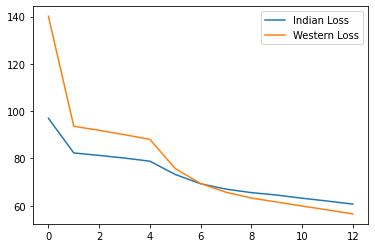

[14,     1] loss: 53.267
[14,     2] loss: 56.706
[14,     3] loss: 56.583
[14,     4] loss: 55.235
[14,     5] loss: 53.059
[14,     6] loss: 52.681
[14,     7] loss: 52.177
[14,     8] loss: 51.394
[14,     9] loss: 54.815
[14,    10] loss: 53.206
[14,    11] loss: 51.696
[14,    12] loss: 49.365
[14,    13] loss: 55.351
[14,    14] loss: 56.924
[14,    15] loss: 51.964
[14,    16] loss: 63.847
[14,    17] loss: 53.296
[14,    18] loss: 56.284
[14,    19] loss: 51.802
[14,    20] loss: 54.215
[14,    21] loss: 53.775
[14,    22] loss: 52.793
[14,    23] loss: 57.703
[14,    24] loss: 54.059
[14,    25] loss: 54.385
[14,    26] loss: 48.618
[14,    27] loss: 54.523
[14,    28] loss: 51.355
[14,    29] loss: 52.324
[14,    30] loss: 54.670
[14,    31] loss: 57.764
[14,    32] loss: 53.578
[14,    33] loss: 57.217
[14,    34] loss: 57.202
[14,    35] loss: 54.364
[14,    36] loss: 54.413
[14,    37] loss: 52.280
[14,    38] loss: 53.702
[14,    39] loss: 53.685
[14,    40] loss: 51.350


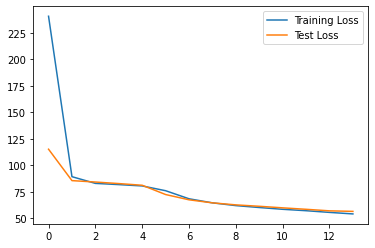

LOSS of the network on the test images: 1083 %
Mean of the network on the Indian images after epoch 13 is 60.21244769626193
LOSS of the network on the test images: 1008 %
Mean of the network on the Western images after epoch 13 is 56.045263078477646


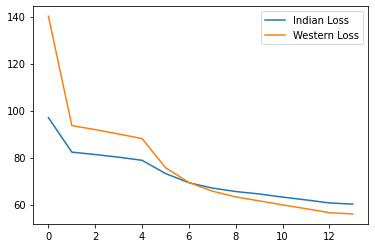

[15,     1] loss: 52.345
[15,     2] loss: 55.662
[15,     3] loss: 55.141
[15,     4] loss: 53.945
[15,     5] loss: 52.127
[15,     6] loss: 51.508
[15,     7] loss: 51.052
[15,     8] loss: 50.605
[15,     9] loss: 53.730
[15,    10] loss: 51.864
[15,    11] loss: 50.514
[15,    12] loss: 48.166
[15,    13] loss: 54.020
[15,    14] loss: 55.784
[15,    15] loss: 50.636
[15,    16] loss: 61.523
[15,    17] loss: 51.576
[15,    18] loss: 54.667
[15,    19] loss: 50.896
[15,    20] loss: 52.506
[15,    21] loss: 52.811
[15,    22] loss: 52.222
[15,    23] loss: 56.176
[15,    24] loss: 52.936
[15,    25] loss: 53.565
[15,    26] loss: 48.530
[15,    27] loss: 53.194
[15,    28] loss: 50.265
[15,    29] loss: 51.124
[15,    30] loss: 53.391
[15,    31] loss: 56.562
[15,    32] loss: 52.170
[15,    33] loss: 55.656
[15,    34] loss: 55.413
[15,    35] loss: 52.808
[15,    36] loss: 53.037
[15,    37] loss: 50.818
[15,    38] loss: 52.181
[15,    39] loss: 52.444
[15,    40] loss: 49.172


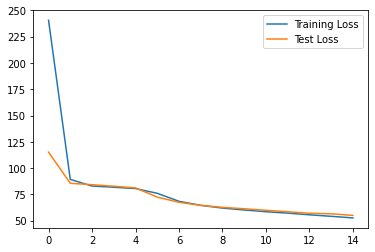

LOSS of the network on the test images: 1059 %
Mean of the network on the Indian images after epoch 14 is 58.858844969007706
LOSS of the network on the test images: 977 %
Mean of the network on the Western images after epoch 14 is 54.293911616007485


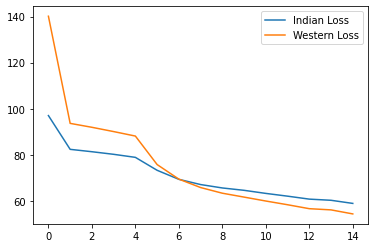

[16,     1] loss: 50.518
[16,     2] loss: 53.469
[16,     3] loss: 54.086
[16,     4] loss: 53.000
[16,     5] loss: 51.019
[16,     6] loss: 50.012
[16,     7] loss: 50.260
[16,     8] loss: 49.300
[16,     9] loss: 52.420
[16,    10] loss: 50.675
[16,    11] loss: 49.725
[16,    12] loss: 47.003
[16,    13] loss: 52.721
[16,    14] loss: 54.126
[16,    15] loss: 49.886
[16,    16] loss: 59.768
[16,    17] loss: 50.411
[16,    18] loss: 53.652
[16,    19] loss: 51.465
[16,    20] loss: 51.505
[16,    21] loss: 52.389
[16,    22] loss: 51.151
[16,    23] loss: 55.561
[16,    24] loss: 51.924
[16,    25] loss: 52.107
[16,    26] loss: 46.801
[16,    27] loss: 52.181
[16,    28] loss: 49.300
[16,    29] loss: 49.965
[16,    30] loss: 52.398
[16,    31] loss: 54.973
[16,    32] loss: 50.973
[16,    33] loss: 54.137
[16,    34] loss: 54.260
[16,    35] loss: 51.438
[16,    36] loss: 51.587
[16,    37] loss: 49.633
[16,    38] loss: 50.638
[16,    39] loss: 51.165
[16,    40] loss: 47.912


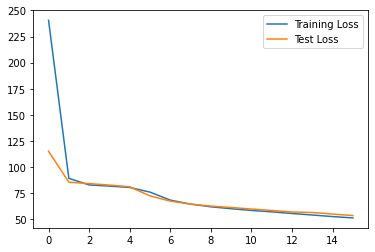

LOSS of the network on the test images: 1032 %
Mean of the network on the Indian images after epoch 15 is 57.37285465664334
LOSS of the network on the test images: 951 %
Mean of the network on the Western images after epoch 15 is 52.87114461263021


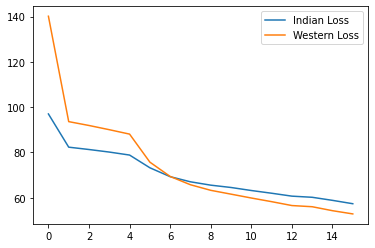

[17,     1] loss: 48.801
[17,     2] loss: 51.925
[17,     3] loss: 52.217
[17,     4] loss: 51.428
[17,     5] loss: 49.487
[17,     6] loss: 48.818
[17,     7] loss: 48.354
[17,     8] loss: 48.015
[17,     9] loss: 50.781
[17,    10] loss: 49.431
[17,    11] loss: 47.972
[17,    12] loss: 45.706
[17,    13] loss: 50.887
[17,    14] loss: 52.770
[17,    15] loss: 48.327
[17,    16] loss: 57.842
[17,    17] loss: 49.002
[17,    18] loss: 51.961
[17,    19] loss: 49.304
[17,    20] loss: 50.183
[17,    21] loss: 50.239
[17,    22] loss: 49.242
[17,    23] loss: 53.519
[17,    24] loss: 50.472
[17,    25] loss: 50.234
[17,    26] loss: 45.070
[17,    27] loss: 50.523
[17,    28] loss: 47.530
[17,    29] loss: 48.284
[17,    30] loss: 50.681
[17,    31] loss: 53.109
[17,    32] loss: 49.214
[17,    33] loss: 52.227
[17,    34] loss: 52.408
[17,    35] loss: 49.598
[17,    36] loss: 50.036
[17,    37] loss: 48.157
[17,    38] loss: 49.010
[17,    39] loss: 49.327
[17,    40] loss: 46.467


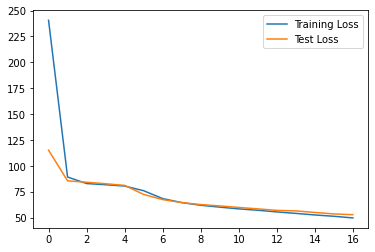

LOSS of the network on the test images: 1021 %
Mean of the network on the Indian images after epoch 16 is 56.72785504659017
LOSS of the network on the test images: 936 %
Mean of the network on the Western images after epoch 16 is 52.02072270711263


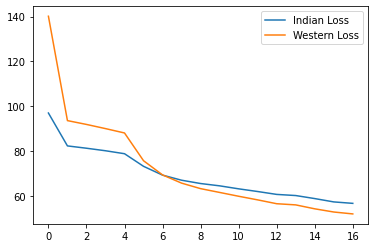

[18,     1] loss: 47.736
[18,     2] loss: 50.582
[18,     3] loss: 50.527
[18,     4] loss: 49.418
[18,     5] loss: 48.335
[18,     6] loss: 47.389
[18,     7] loss: 46.918
[18,     8] loss: 46.684
[18,     9] loss: 49.750
[18,    10] loss: 47.994
[18,    11] loss: 46.403
[18,    12] loss: 44.257
[18,    13] loss: 49.433
[18,    14] loss: 51.205
[18,    15] loss: 46.675
[18,    16] loss: 56.071
[18,    17] loss: 47.765
[18,    18] loss: 49.528
[18,    19] loss: 46.855
[18,    20] loss: 48.319
[18,    21] loss: 48.654
[18,    22] loss: 47.391
[18,    23] loss: 51.547
[18,    24] loss: 48.835
[18,    25] loss: 48.544
[18,    26] loss: 43.585
[18,    27] loss: 48.630
[18,    28] loss: 46.145
[18,    29] loss: 47.155
[18,    30] loss: 49.864
[18,    31] loss: 52.033
[18,    32] loss: 47.958
[18,    33] loss: 50.537
[18,    34] loss: 51.092
[18,    35] loss: 48.644
[18,    36] loss: 48.814
[18,    37] loss: 46.862
[18,    38] loss: 47.666
[18,    39] loss: 48.850
[18,    40] loss: 47.299


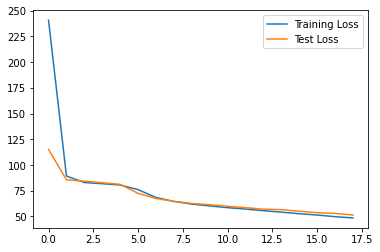

LOSS of the network on the test images: 994 %
Mean of the network on the Indian images after epoch 17 is 55.23051028781467
LOSS of the network on the test images: 908 %
Mean of the network on the Western images after epoch 17 is 50.47382142808702


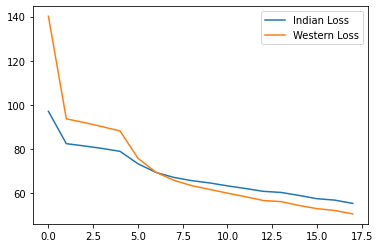

[19,     1] loss: 46.084
[19,     2] loss: 48.584
[19,     3] loss: 49.072
[19,     4] loss: 48.222
[19,     5] loss: 46.738
[19,     6] loss: 45.986
[19,     7] loss: 45.396
[19,     8] loss: 45.119
[19,     9] loss: 47.891
[19,    10] loss: 46.827
[19,    11] loss: 45.221
[19,    12] loss: 43.327
[19,    13] loss: 47.698
[19,    14] loss: 49.885
[19,    15] loss: 45.524
[19,    16] loss: 54.931
[19,    17] loss: 46.932
[19,    18] loss: 48.352
[19,    19] loss: 45.545
[19,    20] loss: 47.596
[19,    21] loss: 48.730
[19,    22] loss: 47.461
[19,    23] loss: 50.574
[19,    24] loss: 47.927
[19,    25] loss: 47.445
[19,    26] loss: 43.111
[19,    27] loss: 47.705
[19,    28] loss: 45.749
[19,    29] loss: 46.611
[19,    30] loss: 48.982
[19,    31] loss: 50.298
[19,    32] loss: 46.566
[19,    33] loss: 49.289
[19,    34] loss: 50.366
[19,    35] loss: 47.870
[19,    36] loss: 47.686
[19,    37] loss: 45.887
[19,    38] loss: 46.480
[19,    39] loss: 47.464
[19,    40] loss: 45.060


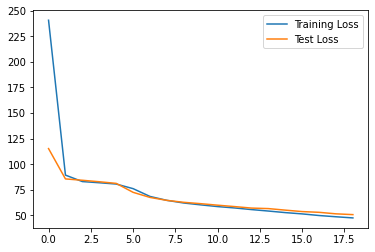

LOSS of the network on the test images: 979 %
Mean of the network on the Indian images after epoch 18 is 54.39940049913194
LOSS of the network on the test images: 895 %
Mean of the network on the Western images after epoch 18 is 49.735799153645836


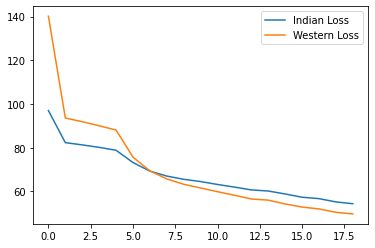

[20,     1] loss: 45.110
[20,     2] loss: 47.594
[20,     3] loss: 47.902
[20,     4] loss: 47.130
[20,     5] loss: 45.580
[20,     6] loss: 44.613
[20,     7] loss: 44.180
[20,     8] loss: 43.948
[20,     9] loss: 46.570
[20,    10] loss: 45.756
[20,    11] loss: 44.286
[20,    12] loss: 41.832
[20,    13] loss: 46.482
[20,    14] loss: 48.678
[20,    15] loss: 44.465
[20,    16] loss: 52.832
[20,    17] loss: 45.624
[20,    18] loss: 47.461
[20,    19] loss: 44.977
[20,    20] loss: 45.222
[20,    21] loss: 46.562
[20,    22] loss: 46.147
[20,    23] loss: 48.754
[20,    24] loss: 47.058
[20,    25] loss: 47.190
[20,    26] loss: 42.586
[20,    27] loss: 45.791
[20,    28] loss: 44.081
[20,    29] loss: 45.084
[20,    30] loss: 47.378
[20,    31] loss: 49.035
[20,    32] loss: 45.833
[20,    33] loss: 48.243
[20,    34] loss: 48.545
[20,    35] loss: 45.888
[20,    36] loss: 46.231
[20,    37] loss: 44.731
[20,    38] loss: 45.273
[20,    39] loss: 45.859
[20,    40] loss: 42.963


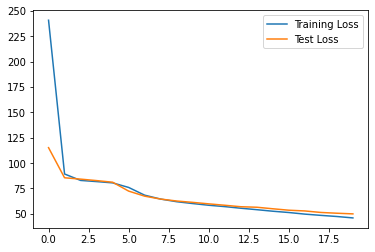

LOSS of the network on the test images: 965 %
Mean of the network on the Indian images after epoch 19 is 53.64312087164985
LOSS of the network on the test images: 885 %
Mean of the network on the Western images after epoch 19 is 49.18855624728732


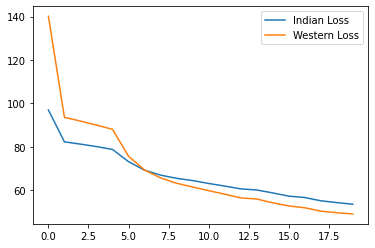

[21,     1] loss: 44.471
[21,     2] loss: 46.429
[21,     3] loss: 47.273
[21,     4] loss: 45.289
[21,     5] loss: 44.680
[21,     6] loss: 43.889
[21,     7] loss: 43.536
[21,     8] loss: 42.527
[21,     9] loss: 46.612
[21,    10] loss: 46.051
[21,    11] loss: 43.125
[21,    12] loss: 41.793
[21,    13] loss: 45.716
[21,    14] loss: 47.336
[21,    15] loss: 43.188
[21,    16] loss: 52.498
[21,    17] loss: 44.985
[21,    18] loss: 45.351
[21,    19] loss: 43.333
[21,    20] loss: 44.873
[21,    21] loss: 45.125
[21,    22] loss: 43.777
[21,    23] loss: 47.895
[21,    24] loss: 46.017
[21,    25] loss: 44.359
[21,    26] loss: 40.666
[21,    27] loss: 45.427
[21,    28] loss: 42.861
[21,    29] loss: 43.170
[21,    30] loss: 46.274
[21,    31] loss: 47.159
[21,    32] loss: 43.893
[21,    33] loss: 47.049
[21,    34] loss: 47.838
[21,    35] loss: 44.267
[21,    36] loss: 45.414
[21,    37] loss: 43.919
[21,    38] loss: 43.972
[21,    39] loss: 44.850
[21,    40] loss: 41.874


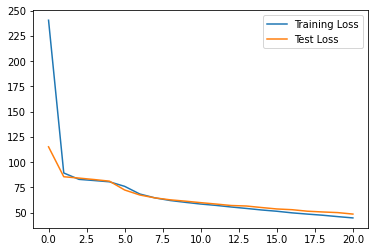

LOSS of the network on the test images: 940 %
Mean of the network on the Indian images after epoch 20 is 52.250611199273
LOSS of the network on the test images: 856 %
Mean of the network on the Western images after epoch 20 is 47.578002293904625


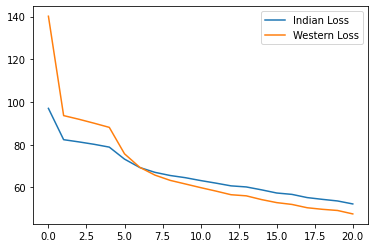

[22,     1] loss: 42.825
[22,     2] loss: 44.551
[22,     3] loss: 45.236
[22,     4] loss: 43.981
[22,     5] loss: 43.218
[22,     6] loss: 42.196
[22,     7] loss: 41.648
[22,     8] loss: 41.257
[22,     9] loss: 44.254
[22,    10] loss: 43.326
[22,    11] loss: 42.072
[22,    12] loss: 39.780
[22,    13] loss: 43.895
[22,    14] loss: 45.670
[22,    15] loss: 41.795
[22,    16] loss: 49.948
[22,    17] loss: 42.831
[22,    18] loss: 43.984
[22,    19] loss: 41.695
[22,    20] loss: 42.302
[22,    21] loss: 42.802
[22,    22] loss: 42.515
[22,    23] loss: 46.046
[22,    24] loss: 43.853
[22,    25] loss: 42.716
[22,    26] loss: 39.123
[22,    27] loss: 43.230
[22,    28] loss: 41.184
[22,    29] loss: 41.859
[22,    30] loss: 44.155
[22,    31] loss: 45.509
[22,    32] loss: 42.398
[22,    33] loss: 44.641
[22,    34] loss: 45.622
[22,    35] loss: 43.067
[22,    36] loss: 43.293
[22,    37] loss: 42.164
[22,    38] loss: 42.663
[22,    39] loss: 42.931
[22,    40] loss: 40.306


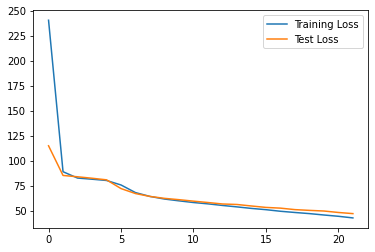

LOSS of the network on the test images: 921 %
Mean of the network on the Indian images after epoch 21 is 51.19201448228624
LOSS of the network on the test images: 833 %
Mean of the network on the Western images after epoch 21 is 46.288534588283966


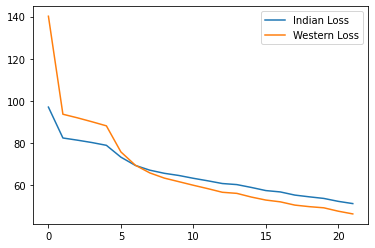

[23,     1] loss: 41.273
[23,     2] loss: 42.912
[23,     3] loss: 43.814
[23,     4] loss: 42.882
[23,     5] loss: 42.072
[23,     6] loss: 40.876
[23,     7] loss: 40.858
[23,     8] loss: 40.191
[23,     9] loss: 42.767
[23,    10] loss: 42.118
[23,    11] loss: 41.185
[23,    12] loss: 38.700
[23,    13] loss: 42.233
[23,    14] loss: 44.645
[23,    15] loss: 40.594
[23,    16] loss: 48.404
[23,    17] loss: 41.950
[23,    18] loss: 43.175
[23,    19] loss: 41.019
[23,    20] loss: 41.074
[23,    21] loss: 41.821
[23,    22] loss: 41.670
[23,    23] loss: 44.923
[23,    24] loss: 42.737
[23,    25] loss: 41.761
[23,    26] loss: 38.564
[23,    27] loss: 42.555
[23,    28] loss: 40.201
[23,    29] loss: 40.854
[23,    30] loss: 43.439
[23,    31] loss: 44.480
[23,    32] loss: 41.111
[23,    33] loss: 43.726
[23,    34] loss: 44.966
[23,    35] loss: 42.672
[23,    36] loss: 42.314
[23,    37] loss: 41.237
[23,    38] loss: 42.003
[23,    39] loss: 42.044
[23,    40] loss: 39.532


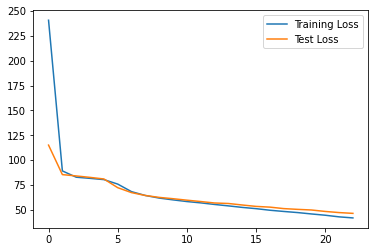

LOSS of the network on the test images: 907 %
Mean of the network on the Indian images after epoch 22 is 50.393798192342125
LOSS of the network on the test images: 818 %
Mean of the network on the Western images after epoch 22 is 45.45743751525879


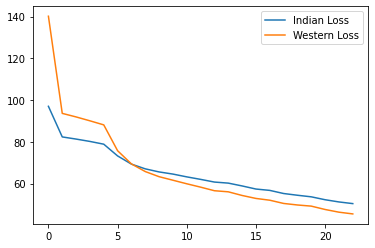

[24,     1] loss: 40.124
[24,     2] loss: 41.699
[24,     3] loss: 42.649
[24,     4] loss: 41.727
[24,     5] loss: 41.061
[24,     6] loss: 39.761
[24,     7] loss: 39.905
[24,     8] loss: 39.295
[24,     9] loss: 41.577
[24,    10] loss: 40.858
[24,    11] loss: 40.143
[24,    12] loss: 37.713
[24,    13] loss: 40.942
[24,    14] loss: 43.242
[24,    15] loss: 39.575
[24,    16] loss: 46.955
[24,    17] loss: 40.625
[24,    18] loss: 41.961
[24,    19] loss: 40.196
[24,    20] loss: 40.135
[24,    21] loss: 40.607
[24,    22] loss: 40.690
[24,    23] loss: 43.726
[24,    24] loss: 41.689
[24,    25] loss: 40.487
[24,    26] loss: 37.523
[24,    27] loss: 41.425
[24,    28] loss: 39.308
[24,    29] loss: 39.635
[24,    30] loss: 42.226
[24,    31] loss: 43.063
[24,    32] loss: 40.144
[24,    33] loss: 42.291
[24,    34] loss: 43.358
[24,    35] loss: 41.004
[24,    36] loss: 41.105
[24,    37] loss: 40.044
[24,    38] loss: 40.768
[24,    39] loss: 40.586
[24,    40] loss: 38.648


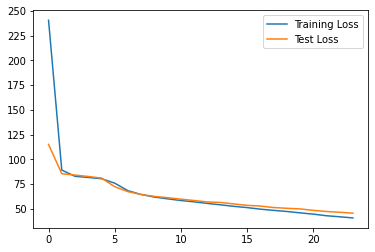

LOSS of the network on the test images: 890 %
Mean of the network on the Indian images after epoch 23 is 49.46713553534614
LOSS of the network on the test images: 800 %
Mean of the network on the Western images after epoch 23 is 44.48493639628092


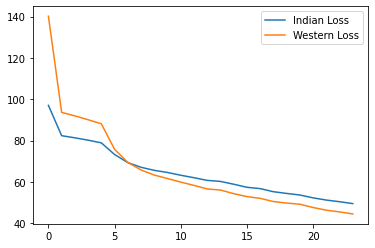

[25,     1] loss: 38.880
[25,     2] loss: 40.531
[25,     3] loss: 41.022
[25,     4] loss: 40.151
[25,     5] loss: 39.940
[25,     6] loss: 39.031
[25,     7] loss: 38.688
[25,     8] loss: 38.090
[25,     9] loss: 40.483
[25,    10] loss: 40.291
[25,    11] loss: 39.494
[25,    12] loss: 36.918
[25,    13] loss: 39.669
[25,    14] loss: 42.204
[25,    15] loss: 38.895
[25,    16] loss: 45.801
[25,    17] loss: 39.595
[25,    18] loss: 40.740
[25,    19] loss: 40.021
[25,    20] loss: 40.140
[25,    21] loss: 39.916
[25,    22] loss: 39.301
[25,    23] loss: 42.415
[25,    24] loss: 41.333
[25,    25] loss: 40.053
[25,    26] loss: 36.668
[25,    27] loss: 40.190
[25,    28] loss: 38.176
[25,    29] loss: 39.028
[25,    30] loss: 41.355
[25,    31] loss: 42.403
[25,    32] loss: 39.528
[25,    33] loss: 41.166
[25,    34] loss: 42.152
[25,    35] loss: 39.725
[25,    36] loss: 39.702
[25,    37] loss: 39.233
[25,    38] loss: 39.729
[25,    39] loss: 39.526
[25,    40] loss: 37.738


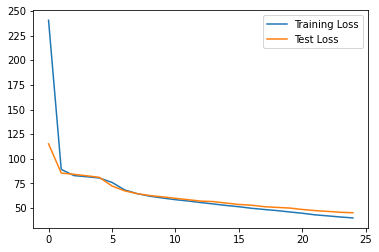

LOSS of the network on the test images: 882 %
Mean of the network on the Indian images after epoch 24 is 49.03456052144369
LOSS of the network on the test images: 791 %
Mean of the network on the Western images after epoch 24 is 43.97408760918511


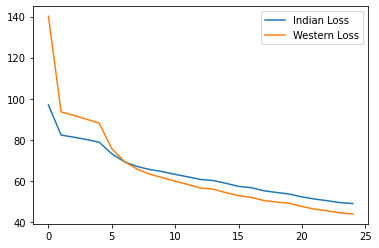

[26,     1] loss: 37.977
[26,     2] loss: 39.642
[26,     3] loss: 39.986
[26,     4] loss: 39.204
[26,     5] loss: 39.076
[26,     6] loss: 37.975
[26,     7] loss: 37.716
[26,     8] loss: 37.125
[26,     9] loss: 39.773
[26,    10] loss: 39.533
[26,    11] loss: 38.584
[26,    12] loss: 35.866
[26,    13] loss: 38.894
[26,    14] loss: 41.395
[26,    15] loss: 37.865
[26,    16] loss: 44.461
[26,    17] loss: 39.369
[26,    18] loss: 40.167
[26,    19] loss: 38.376
[26,    20] loss: 38.024
[26,    21] loss: 40.131
[26,    22] loss: 41.194
[26,    23] loss: 42.737
[26,    24] loss: 39.973
[26,    25] loss: 40.094
[26,    26] loss: 38.383
[26,    27] loss: 42.766
[26,    28] loss: 38.560
[26,    29] loss: 38.455
[26,    30] loss: 40.929
[26,    31] loss: 42.043
[26,    32] loss: 40.243
[26,    33] loss: 41.547
[26,    34] loss: 41.714
[26,    35] loss: 40.106
[26,    36] loss: 39.599
[26,    37] loss: 38.759
[26,    38] loss: 39.097
[26,    39] loss: 39.536
[26,    40] loss: 37.083


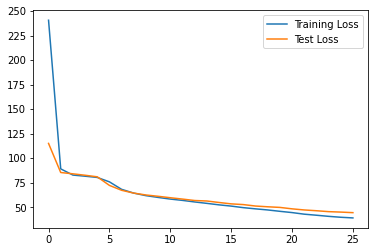

LOSS of the network on the test images: 871 %
Mean of the network on the Indian images after epoch 25 is 48.432649824354385
LOSS of the network on the test images: 781 %
Mean of the network on the Western images after epoch 25 is 43.400112575954864


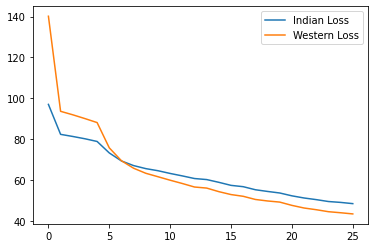

[27,     1] loss: 37.158
[27,     2] loss: 39.407
[27,     3] loss: 39.232
[27,     4] loss: 38.332
[27,     5] loss: 38.597
[27,     6] loss: 37.727
[27,     7] loss: 36.921
[27,     8] loss: 36.875
[27,     9] loss: 41.078
[27,    10] loss: 39.060
[27,    11] loss: 37.306
[27,    12] loss: 36.616
[27,    13] loss: 38.483
[27,    14] loss: 39.707
[27,    15] loss: 37.897
[27,    16] loss: 44.016
[27,    17] loss: 38.110
[27,    18] loss: 38.972
[27,    19] loss: 38.492
[27,    20] loss: 38.729
[27,    21] loss: 37.797
[27,    22] loss: 38.176
[27,    23] loss: 41.670
[27,    24] loss: 39.636
[27,    25] loss: 37.530
[27,    26] loss: 35.963
[27,    27] loss: 39.547
[27,    28] loss: 37.088
[27,    29] loss: 37.415
[27,    30] loss: 40.048
[27,    31] loss: 40.295
[27,    32] loss: 37.418
[27,    33] loss: 39.678
[27,    34] loss: 40.706
[27,    35] loss: 38.117
[27,    36] loss: 38.190
[27,    37] loss: 37.488
[27,    38] loss: 37.886
[27,    39] loss: 37.709
[27,    40] loss: 36.118


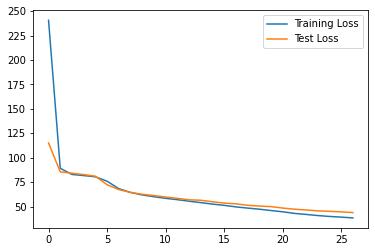

LOSS of the network on the test images: 857 %
Mean of the network on the Indian images after epoch 26 is 47.61532020568848
LOSS of the network on the test images: 769 %
Mean of the network on the Western images after epoch 26 is 42.75610669453939


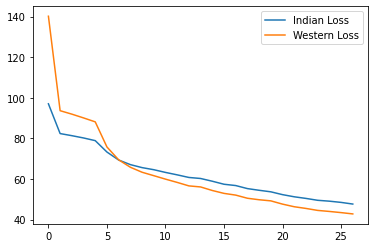

[28,     1] loss: 36.143
[28,     2] loss: 37.651
[28,     3] loss: 38.291
[28,     4] loss: 36.918
[28,     5] loss: 37.584
[28,     6] loss: 36.092
[28,     7] loss: 36.006
[28,     8] loss: 35.835
[28,     9] loss: 38.342
[28,    10] loss: 37.192
[28,    11] loss: 36.458
[28,    12] loss: 34.645
[28,    13] loss: 36.550
[28,    14] loss: 38.674
[28,    15] loss: 36.215
[28,    16] loss: 41.627
[28,    17] loss: 37.212
[28,    18] loss: 37.433
[28,    19] loss: 35.885
[28,    20] loss: 36.438
[28,    21] loss: 36.933
[28,    22] loss: 36.648
[28,    23] loss: 39.315
[28,    24] loss: 37.995
[28,    25] loss: 36.567
[28,    26] loss: 33.926
[28,    27] loss: 37.210
[28,    28] loss: 35.575
[28,    29] loss: 35.921
[28,    30] loss: 37.862
[28,    31] loss: 38.780
[28,    32] loss: 36.033
[28,    33] loss: 38.075
[28,    34] loss: 39.194
[28,    35] loss: 37.103
[28,    36] loss: 36.512
[28,    37] loss: 36.567
[28,    38] loss: 36.918
[28,    39] loss: 36.617
[28,    40] loss: 35.262


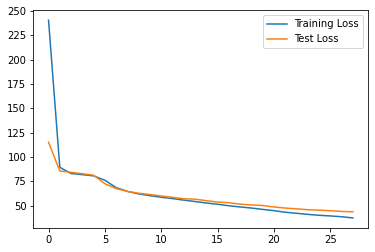

LOSS of the network on the test images: 850 %
Mean of the network on the Indian images after epoch 27 is 47.23979187011719
LOSS of the network on the test images: 762 %
Mean of the network on the Western images after epoch 27 is 42.336631774902344


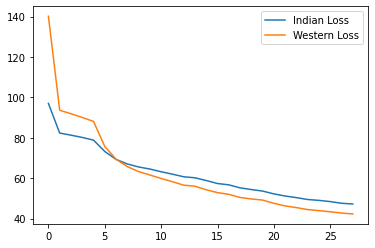

[29,     1] loss: 35.221
[29,     2] loss: 37.045
[29,     3] loss: 37.571
[29,     4] loss: 36.024
[29,     5] loss: 36.882
[29,     6] loss: 35.772
[29,     7] loss: 34.916
[29,     8] loss: 35.210
[29,     9] loss: 37.863
[29,    10] loss: 36.066
[29,    11] loss: 36.158
[29,    12] loss: 33.759
[29,    13] loss: 35.812
[29,    14] loss: 38.118
[29,    15] loss: 35.353
[29,    16] loss: 41.038
[29,    17] loss: 36.841
[29,    18] loss: 36.501
[29,    19] loss: 35.353
[29,    20] loss: 36.069
[29,    21] loss: 35.915
[29,    22] loss: 36.057
[29,    23] loss: 38.620
[29,    24] loss: 37.217
[29,    25] loss: 36.350
[29,    26] loss: 33.453
[29,    27] loss: 36.660
[29,    28] loss: 34.715
[29,    29] loss: 35.380
[29,    30] loss: 37.071
[29,    31] loss: 37.886
[29,    32] loss: 35.639
[29,    33] loss: 37.273
[29,    34] loss: 38.049
[29,    35] loss: 36.151
[29,    36] loss: 35.835
[29,    37] loss: 35.610
[29,    38] loss: 35.642
[29,    39] loss: 36.068
[29,    40] loss: 34.300


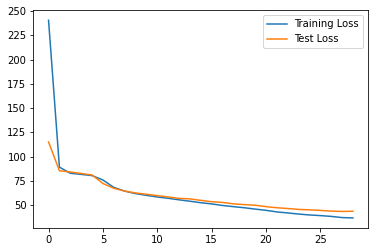

LOSS of the network on the test images: 852 %
Mean of the network on the Indian images after epoch 28 is 47.357293870713974
LOSS of the network on the test images: 769 %
Mean of the network on the Western images after epoch 28 is 42.7326594458686


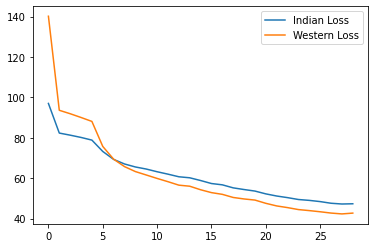

[30,     1] loss: 35.576
[30,     2] loss: 36.459
[30,     3] loss: 37.434
[30,     4] loss: 37.434
[30,     5] loss: 35.998
[30,     6] loss: 35.647
[30,     7] loss: 35.018
[30,     8] loss: 34.077
[30,     9] loss: 36.830
[30,    10] loss: 35.847
[30,    11] loss: 35.295
[30,    12] loss: 32.963
[30,    13] loss: 35.328
[30,    14] loss: 37.028
[30,    15] loss: 35.362
[30,    16] loss: 40.350
[30,    17] loss: 35.676
[30,    18] loss: 36.224
[30,    19] loss: 35.102
[30,    20] loss: 34.851
[30,    21] loss: 35.562
[30,    22] loss: 35.395
[30,    23] loss: 38.050
[30,    24] loss: 36.986
[30,    25] loss: 35.360
[30,    26] loss: 33.296
[30,    27] loss: 35.646
[30,    28] loss: 34.232
[30,    29] loss: 34.806
[30,    30] loss: 36.140
[30,    31] loss: 37.745
[30,    32] loss: 35.075
[30,    33] loss: 36.343
[30,    34] loss: 37.998
[30,    35] loss: 36.073
[30,    36] loss: 35.124
[30,    37] loss: 35.892
[30,    38] loss: 35.221
[30,    39] loss: 35.592
[30,    40] loss: 33.914


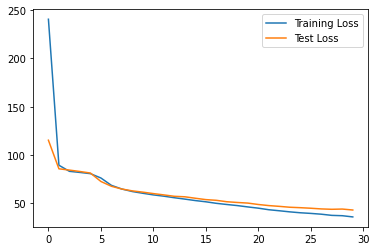

LOSS of the network on the test images: 836 %
Mean of the network on the Indian images after epoch 29 is 46.45843166775174
LOSS of the network on the test images: 748 %
Mean of the network on the Western images after epoch 29 is 41.59601910909017


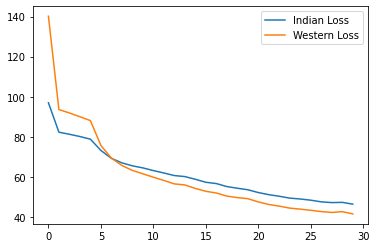

Finished Training


In [29]:
train_loss_graph = []
test_loss_graph = []

indian_loss_graph = []
western_loss_graph = []

for epoch in range(n_epochs):  # loop over the dataset multiple times

    running_loss = 0.0
    total_Loss = 0.0
    correct = 0
    total = 0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels, fileNames = data
        inputs, labels = inputs.to(device), labels.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, inputs)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        total_Loss += loss.item()

        if i % print_every == 0:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / print_every))
            running_loss = 0.0
    
    print('LOSS of the network on the train images after epoch {} is {}'.format(epoch, total_Loss) )
    if reduction_loss == "mean":
      total_Loss = total_Loss/i
      print('Mean of the network on the train images after epoch {} is {}'.format(epoch, total_Loss) )
    
    train_loss_graph.append(total_Loss)
    correct = 0
    total = 0
    running_loss = 0.0
    total_Loss = 0.0
    # since we're not training, we don't need to calculate the gradients for our outputs
    with torch.no_grad():
        for j, data in enumerate(testloader,0):
            inputs, labels, fileNames = data
            inputs, labels = inputs.to(device), labels.to(device)
            # calculate outputs by running images through the network
            outputs = net(inputs)
            loss = criterion(outputs, inputs)
            running_loss += loss.item()
            total_Loss += loss.item()

    print('LOSS of the network on the test images: %d %%' % (total_Loss))
    if reduction_loss == "mean":
      total_Loss = total_Loss/j
      print('Mean of the network on the train images after epoch {} is {}'.format(epoch, total_Loss) )
      
    
    test_loss_graph.append(total_Loss)
    visualize(train_loss_graph, test_loss_graph)


    running_loss = 0.0
    total_Loss = 0.0
    # since we're not training, we don't need to calculate the gradients for our outputs
    with torch.no_grad():
        for j, data in enumerate(indian_loader,0):
            inputs, labels, fileNames = data
            inputs, labels = inputs.to(device), labels.to(device)
            # calculate outputs by running images through the network
            outputs = net(inputs)
            loss = criterion(outputs, inputs)
            running_loss += loss.item()
            total_Loss += loss.item()

    print('LOSS of the network on the test images: %d %%' % (total_Loss))
    if reduction_loss == "mean":
      total_Loss = total_Loss/j
      print('Mean of the network on the Indian images after epoch {} is {}'.format(epoch, total_Loss) )

    indian_loss_graph.append(total_Loss)

    running_loss = 0.0
    total_Loss = 0.0
    # since we're not training, we don't need to calculate the gradients for our outputs
    with torch.no_grad():
        for j, data in enumerate(western_loader,0):
            inputs, labels, fileNames = data
            inputs, labels = inputs.to(device), labels.to(device)
            # calculate outputs by running images through the network
            outputs = net(inputs)
            loss = criterion(outputs, inputs)
            running_loss += loss.item()
            total_Loss += loss.item()

    print('LOSS of the network on the test images: %d %%' % (total_Loss))
    if reduction_loss == "mean":
      total_Loss = total_Loss/j
      print('Mean of the network on the Western images after epoch {} is {}'.format(epoch, total_Loss) )

    western_loss_graph.append(total_Loss)

    visualize_class_loss(indian_loss_graph, western_loss_graph)
          

print('Finished Training')

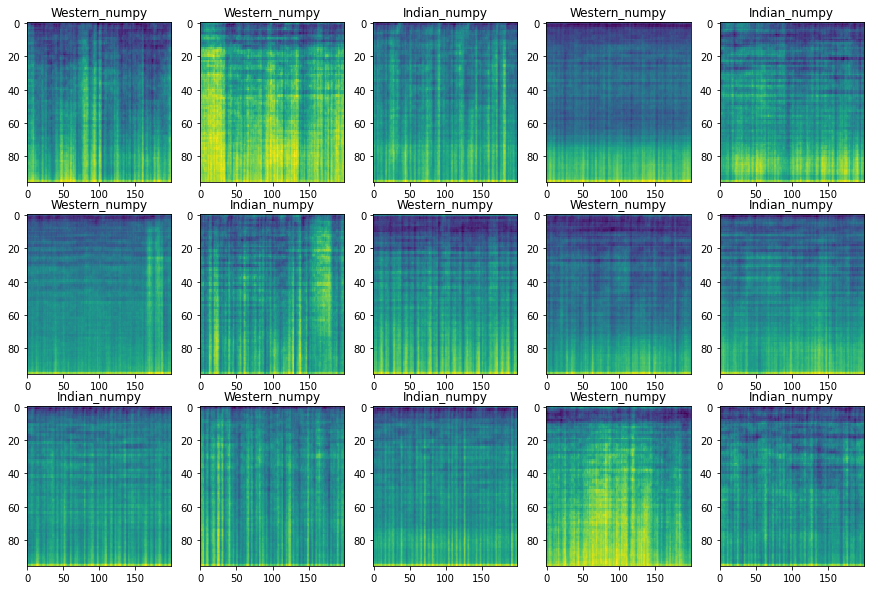

In [30]:
# get some random training images
dataiter = iter(testloader)
images, labels, fileNames = dataiter.next()
arthopod_types = {0: 'Indian_numpy', 1: 'Western_numpy', 2: 'country', 3: 'disco', 4: 'hiphop', 5: 'jazz', 6: 'metal', 7: 'pop', 8: 'reggae', 9: 'rock'}
# Viewing data examples used for training
fig, axis = plt.subplots(3, 5, figsize=(15, 10))
for i, ax in enumerate(axis.flat):
    with torch.no_grad():
        image, label = images[i], labels[i]
        image, labels = image.to(device), labels.to(device)
        output_img = net(image.unsqueeze(dim=0))
        ax.imshow(mel_display(output_img.detach().cpu()), interpolation='nearest', aspect='auto') # add image
        ax.set(title = f"{arthopod_types[label.item()]}") # add label

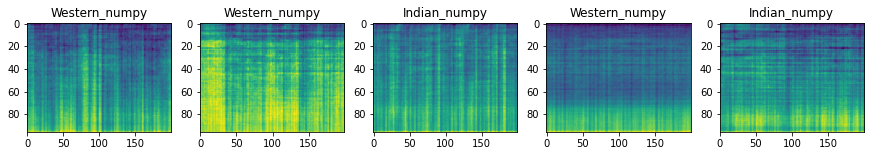

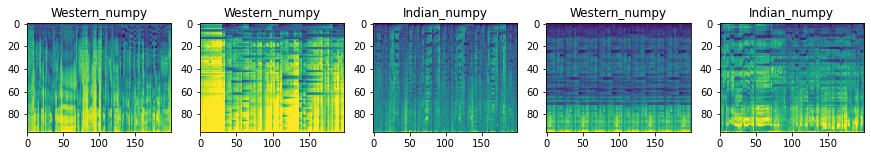

In [31]:
# get some random training images
outputs=[]
dataiter = iter(testloader)
images, labels, fileNames = dataiter.next()
arthopod_types = {0: 'Indian_numpy', 1: 'Western_numpy', 2: 'country', 3: 'disco', 4: 'hiphop', 5: 'jazz', 6: 'metal', 7: 'pop', 8: 'reggae', 9: 'rock'}
# Viewing data examples used for training
fig, axis = plt.subplots(1, 5, figsize=(15, 2))
for i, ax in enumerate(axis.flat):
    with torch.no_grad():
        image, label = images[i], labels[i]
        image, labels = image.to(device), labels.to(device)
        output_img = net(image.unsqueeze(dim=0))
        ax.imshow(mel_display(output_img.detach().cpu()), interpolation='nearest', aspect='auto') # add image
        outputs.append((mel_display(image.detach().cpu().unsqueeze(dim=0)),arthopod_types[label.item()] ))
        ax.set(title = f"{arthopod_types[label.item()]}") # add label

fig, axis = plt.subplots(1, 5, figsize=(15, 2))
for ax , (image, label) in zip(axis.flat, outputs):
    ax.imshow(image, interpolation='nearest', aspect='auto') # add image
    ax.set(title = f"{label}") # add label
    
        

In [32]:
torch.save(net.state_dict(), os.path.join(BASE_PATH, "final_model.pt"))

Start evaluation - Test model

In [33]:
model = RecurrentAutoencoder(seq_len, input_bins, AE_encoded_dim, device=device)
model.load_state_dict(torch.load(os.path.join(BASE_PATH, "final_model.pt"), map_location=device))

<All keys matched successfully>

Combined data set recinstruction

In [ ]:
combined_dataset = MEL_Dataset(dataDF,os.path.join(DATA_BASE_PATH, DATA_IMG_DIR),transform)
combinedloader = torch.utils.data.DataLoader(combined_dataset, batch_size=batch_size)

In [ ]:
# dataDF
# dataDF.loc[1, 'labels']
# classes
# os.path.join(BASE_PATH, "Activations_64", str(classes[label]))

In [ ]:
for class_ in classes:
  dir = os.path.join(BASE_PATH, "Activations_64",  str(class_))
  for f in os.listdir(dir):
    os.remove(os.path.join(dir, f))

for class_ in classes:
  dir = os.path.join(BASE_PATH, "Activations_128", str(class_))
  for f in os.listdir(dir):
    os.remove(os.path.join(dir, f))

for class_ in classes:
  dir = os.path.join(BASE_PATH, "reconstructions", str(class_))
  for f in os.listdir(dir):
    os.remove(os.path.join(dir, f))

for class_ in classes:
  dir = os.path.join(BASE_PATH, "originals",  str(class_))
  for f in os.listdir(dir):
    os.remove(os.path.join(dir, f))

In [ ]:
id = 0
with torch.no_grad():
    for data in combinedloader:
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        output_l2, output_l1 = model.encoder(inputs)
        output = model(inputs)
        output_l2 = output_l2.detach().cpu().numpy()
        output_l1 = output_l1.detach().cpu().numpy()
        output = output.detach().cpu().numpy()
        labels = labels.detach().cpu().numpy()
        
        for  arr64, arr128, arr48, label in zip(output_l2, output_l1, output, labels):
          print(os.path.join(BASE_PATH, "Activations_64", str(classes[label]), str(id) + ".npy"))
          np.save(os.path.join(BASE_PATH, "Activations_64", str(classes[label]), str(id) + ".npy"),np.transpose(arr64, (1,0)))
          np.save(os.path.join(BASE_PATH, "Activations_128", classes[label] ,  str(id) + ".npy" ), np.transpose(arr128, (1,0)))
          np.save(os.path.join(BASE_PATH, "reconstructions", classes[label] ,  str(id) + ".npy"), np.transpose(arr48, (1,0)))
          id = id + 1

Strict data separation

In [44]:
for class_ in classes:
  dir = os.path.join(BASE_PATH, "Activations_64", "test", str(class_))
  #print("removing ", dir)
  for f in os.listdir(dir):
    #print("removing ", os.path.join(dir, f))
    os.remove(os.path.join(dir, f))

for class_ in classes:
  dir = os.path.join(BASE_PATH, "Activations_128", "test", str(class_))
  for f in os.listdir(dir):
    os.remove(os.path.join(dir, f))

for class_ in classes:
  dir = os.path.join(BASE_PATH, "reconstructions", "test", str(class_))
  for f in os.listdir(dir):
    os.remove(os.path.join(dir, f))

for class_ in classes:
  dir = os.path.join(BASE_PATH, "originals", "test", str(class_))
  for f in os.listdir(dir):
    os.remove(os.path.join(dir, f))


for class_ in classes:
  dir = os.path.join(BASE_PATH, "Activations_64", "training", str(class_))
  for f in os.listdir(dir):
    os.remove(os.path.join(dir, f))

for class_ in classes:
  dir = os.path.join(BASE_PATH, "Activations_128", "training", str(class_))
  for f in os.listdir(dir):
    os.remove(os.path.join(dir, f))

for class_ in classes:
  dir = os.path.join(BASE_PATH, "reconstructions", "training", str(class_))
  for f in os.listdir(dir):
    os.remove(os.path.join(dir, f))

for class_ in classes:
  dir = os.path.join(BASE_PATH, "originals", "training", str(class_))
  for f in os.listdir(dir):
    os.remove(os.path.join(dir, f))

In [45]:
id_test = 0
with torch.no_grad():
    for data_test in testloader:
        inputs, labels, fileNames = data_test
        inputs, labels = inputs.to(device), labels.to(device)
        output_l2, output_l1 = model.encoder(inputs)
        output = model(inputs)
        output_l2 = output_l2.detach().cpu().numpy()
        output_l1 = output_l1.detach().cpu().numpy()
        output = output.detach().cpu().numpy()
        labels = labels.detach().cpu().numpy()
        inputs = inputs.detach().cpu().numpy()
        
        for  orr48, arr64, arr128, arr48, label, fileName in zip(inputs, output_l2, output_l1, output, labels, fileNames):
          print(os.path.join(BASE_PATH, "Activations_64", "test", str(classes[label]), str(fileName)))
          np.save(os.path.join(BASE_PATH, "Activations_64", "test",str(classes[label]), str(fileName)),np.transpose(arr64, (1,0)))
          np.save(os.path.join(BASE_PATH, "Activations_128", "test",classes[label] ,  str(fileName)), np.transpose(arr128, (1,0)))
          np.save(os.path.join(BASE_PATH, "reconstructions", "test",classes[label] ,  str(fileName)), np.transpose(arr48, (1,0)))
          np.save(os.path.join(BASE_PATH, "originals", "test",classes[label] ,  str(fileName)), np.transpose(orr48, (1,0)))
          id_test = id_test + 1




/content/gdrive/My Drive/vajra/AE_HYBRID_COMBINED/Activations_64/test/Western_numpy/052126_mel_1.npy
/content/gdrive/My Drive/vajra/AE_HYBRID_COMBINED/Activations_64/test/Western_numpy/131323_mel_0.npy
/content/gdrive/My Drive/vajra/AE_HYBRID_COMBINED/Activations_64/test/Indian_numpy/Urvashi_mel_0.npy
/content/gdrive/My Drive/vajra/AE_HYBRID_COMBINED/Activations_64/test/Western_numpy/111460_mel_0.npy
/content/gdrive/My Drive/vajra/AE_HYBRID_COMBINED/Activations_64/test/Indian_numpy/KaunTujhe_mel_0.npy
/content/gdrive/My Drive/vajra/AE_HYBRID_COMBINED/Activations_64/test/Western_numpy/044799_mel_1.npy
/content/gdrive/My Drive/vajra/AE_HYBRID_COMBINED/Activations_64/test/Indian_numpy/MottaModatisari_mel_2.npy
/content/gdrive/My Drive/vajra/AE_HYBRID_COMBINED/Activations_64/test/Western_numpy/082916_mel_1.npy
/content/gdrive/My Drive/vajra/AE_HYBRID_COMBINED/Activations_64/test/Western_numpy/085422_mel_0.npy
/content/gdrive/My Drive/vajra/AE_HYBRID_COMBINED/Activations_64/test/Indian_nump

In [46]:
id_train = 0
with torch.no_grad():
    for data in trainloader:
        inputs, labels, fileNames = data
        inputs, labels = inputs.to(device), labels.to(device)
        output_l2, output_l1 = model.encoder(inputs)
        output = model(inputs)
        output_l2 = output_l2.detach().cpu().numpy()
        output_l1 = output_l1.detach().cpu().numpy()
        output = output.detach().cpu().numpy()
        labels = labels.detach().cpu().numpy()
        inputs = inputs.detach().cpu().numpy()
        
        for  orr48, arr64, arr128, arr48, label, fileName in zip(inputs, output_l2, output_l1, output, labels, fileNames):
          print(os.path.join(BASE_PATH, "Activations_64", "training", str(classes[label]), str(fileName)))
          np.save(os.path.join(BASE_PATH, "Activations_64", "training",str(classes[label]), str(fileName)),np.transpose(arr64, (1,0)))
          np.save(os.path.join(BASE_PATH, "Activations_128", "training",classes[label] ,  str(fileName)), np.transpose(arr128, (1,0)))
          np.save(os.path.join(BASE_PATH, "reconstructions", "training",classes[label] ,  str(fileName)), np.transpose(arr48, (1,0)))
          np.save(os.path.join(BASE_PATH, "originals", "training",classes[label] ,  str(fileName)), np.transpose(orr48, (1,0)))
          id_train = id_train + 1

Streaming output truncated to the last 5000 lines.
/content/gdrive/My Drive/vajra/AE_HYBRID_COMBINED/Activations_64/training/Western_numpy/061007_mel_0.npy
/content/gdrive/My Drive/vajra/AE_HYBRID_COMBINED/Activations_64/training/Indian_numpy/RaahEFakira_mel_1.npy
/content/gdrive/My Drive/vajra/AE_HYBRID_COMBINED/Activations_64/training/Indian_numpy/Poonkattey_mel_2.npy
/content/gdrive/My Drive/vajra/AE_HYBRID_COMBINED/Activations_64/training/Indian_numpy/PCR_mel_2.npy
/content/gdrive/My Drive/vajra/AE_HYBRID_COMBINED/Activations_64/training/Western_numpy/001443_mel_0.npy
/content/gdrive/My Drive/vajra/AE_HYBRID_COMBINED/Activations_64/training/Indian_numpy/WheresThePartyTonight_mel_0.npy
/content/gdrive/My Drive/vajra/AE_HYBRID_COMBINED/Activations_64/training/Western_numpy/025216_mel_0.npy
/content/gdrive/My Drive/vajra/AE_HYBRID_COMBINED/Activations_64/training/Indian_numpy/DhaariChoodu_mel_0.npy
/content/gdrive/My Drive/vajra/AE_HYBRID_COMBINED/Activations_64/training/Western_numpy